# XGBoost models informed by feature selection analysis (using 1 k-fold)

(based on the notebook 044_xgb_1fold_19_features_accuracy_importance_shap.ipynb: that notebook had 4 features plus the 15 individual NIHSS scores. Now using 7 features in the model, so this experiment is using the 6 chosen features plus the 15 individual NIHSS scores in place of the single stroke_severity feature.)

### Plain English summary

The results from this model is used to analyse the contribution of the individual NIHSS features, rather than using the single stroke severity feature.

Use the first kfold as seen performance of model is consistent across the 5 data divisions.

This model (#44) includes 21 features (the 6 selected features and the 15 individual NIHSS features): ["prior_disability", "stroke_team", "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", "precise_onset_known", "nihss_arrival_loc", "nihss_arrival_loc_questions", "nihss_arrival_loc_commands","nihss_arrival_best_gaze","nihss_arrival_visual","nihss_arrival_facial_palsy","nihss_arrival_motor_arm_left", "nihss_arrival_motor_arm_right", "nihss_arrival_motor_leg_left", "nihss_arrival_motor_leg_right","nihss_arrival_limb_ataxia", "nihss_arrival_sensory","nihss_arrival_best_language","nihss_arrival_dysarthria", "nihss_arrival_extinction_inattention"]


### Model and data
XGBoost (multiclass classification model) to predict patient outcome discharge at discharge (mRS 0, 1, 2, 3, 4, 5 or 6).\

A single model made up of a separate model per mRS level, that gives the probablity of being each mRS level, and the sum of them all equals 1 ("softmax"), and prediction is the mRS level with the highest probability.\

21 features: ["prior_disability", "stroke_team", "age", "onset_to_thrombolysis_time", "nihss_arrival_loc", "nihss_arrival_loc_questions", "nihss_arrival_loc_commands","nihss_arrival_best_gaze","nihss_arrival_visual","nihss_arrival_facial_palsy","nihss_arrival_motor_arm_left", "nihss_arrival_motor_arm_right", "nihss_arrival_motor_leg_left", "nihss_arrival_motor_leg_right","nihss_arrival_limb_ataxia", "nihss_arrival_sensory","nihss_arrival_best_language","nihss_arrival_dysarthria", "nihss_arrival_extinction_inattention"]\

Use just the first k-fold\

### Aims
The results from this model is used to analyse the contribution of the individual NIHSS features, rather than using the single stroke severity feature.

### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb


##### Other models in this set
model40: simple with 5 features (compare others to this - what we thought would be our feature selection. Check not missing anything by running the other models)\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis_time"]

model41: Four features (compare this to the two models with a duration (model41 with onset-to-thrombolysis-time and model42 with scan-to-thrombolysis-time)\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age"]

model42 Is it reasonable to replace scan_to_thrombolysis with onset_to_thrombolysis time (the AUC using the 4 other features plus i. scan to IVT, or ii. arrival the IVT).\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age", "scan_to_thrombolysis"]

model43 What information does Year add? Is it a general trend for year. A dip in covid year?\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis", "year"]

model44 What information does the individual NIHSS scores add over the stroke severity feature. Which contributes what?\
key_features = ["prior_disability", "stroke_team", "age", "onset_to_thrombolysis", "nihss_arrival_loc", "nihss_arrival_loc_questions",
                "nihss_arrival_loc_commands","nihss_arrival_best_gaze","nihss_arrival_visual",
                "nihss_arrival_facial_palsy","nihss_arrival_motor_arm_left","nihss_arrival_motor_arm_right",
                "nihss_arrival_motor_leg_left","nihss_arrival_motor_leg_right","nihss_arrival_limb_ataxia",
                "nihss_arrival_sensory","nihss_arrival_best_language","nihss_arrival_dysarthria",
                "nihss_arrival_extinction_inattention"]

model45 What information does atrial_fibrilation give the model? The feature selection process cselected existing diagnosis (atrial_fibrilliation) and new diagnosis (new_afib_diagnosis), but not the single feature that contains the information of both of these (any_afib_diagnosis).\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis", "atrial_fibrillation"]

model46 What information does new_afib_diagnosis give the model? The feature selection process cselected existing diagnosis (atrial_fibrilliation) and new diagnosis (new_afib_diagnosis), but not the single feature that contains the information of both of these (any_afib_diagnosis).\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis", "new_afib_diagnosis"]

model47 What information does any_afib_diagnosis give the model? The feature selection process cselected existing diagnosis (atrial_fibrilliation) and new diagnosis (new_afib_diagnosis), but not the single feature that contains the information of both of these (any_afib_diagnosis).\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis", "any_afib_diagnosis"]

model48 What information does "thrombolysis_no_but_improving" add?\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis", "thrombolysis_no_but_improving"]

model49 What information does "thrombolysis_no_but_other_medical" add?\
key_features = ["prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis", "thrombolysis_no_but_other_medical"]

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from dataclasses import dataclass

import seaborn as sns

import pickle
import shap

from os.path import exists

import math

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

Choose number of kfolds (either =1 for the first kfold, or =5 for the full 5 kfold split)

In [3]:
n_kfold = 1

Select the features for the model

In [4]:
selected_features = ["prior_disability", "stroke_team", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known", 
                     "nihss_arrival_loc", "nihss_arrival_loc_questions", 
                     "nihss_arrival_loc_commands","nihss_arrival_best_gaze","nihss_arrival_visual",
                     "nihss_arrival_facial_palsy","nihss_arrival_motor_arm_left",
                     "nihss_arrival_motor_arm_right", "nihss_arrival_motor_leg_left",
                     "nihss_arrival_motor_leg_right","nihss_arrival_limb_ataxia",
                     "nihss_arrival_sensory","nihss_arrival_best_language","nihss_arrival_dysarthria",
                     "nihss_arrival_extinction_inattention"]
n_features = len(selected_features)
selected_features.append('discharge_disability')

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
#    output_save_path: str = './output/'
    image_save_path: str = './saved_images/'
    data_save_path: str = './saved_data/'
    model_save_path: str = './saved_models/'
    data_read_path: str = '../data_processing/output/kfold_5fold/'
    model_text: str = f'xgb_{n_features}_features_{n_kfold}_kfold'
    notebook: str = '024'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.output_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Read in the first k fold data split

In [7]:
train_data_kfold, test_data_kfold = [], []

for k in range(n_kfold):
    # Read in training set, restrict to chosen features, rename titles, & store
    train = pd.read_csv(paths.data_read_path + '03_train_{0}.csv'.format(k))
#    train.rename(columns=dict_feature_name, inplace=True)
    train = train[selected_features]
    train_data_kfold.append(train)

    test = pd.read_csv(paths.data_read_path + '03_test_{0}.csv'.format(k))
#    test.rename(columns=dict_feature_name, inplace=True)
    test = test[selected_features]
    test_data_kfold.append(test)

Store the output classes

In [9]:
class_names = train_data_kfold[0]['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [10]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """
    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [11]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [12]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        for k in range(n_kfold):
            train_data_kfold[k] = convert_feature_to_one_hot(train_data_kfold[k], feature, prefix)
            test_data_kfold[k] = convert_feature_to_one_hot(test_data_kfold[k], feature, prefix)

Feature names with one hot encoding

In [13]:
features_ohe = list(train_data_kfold[0])
features_ohe.remove("discharge_disability")
n_features_ohe = len(features_ohe)
print(f"There are {n_features} original input features (before one-hot encoding)")
print(f"There are {n_features_ohe} input features (after one-hot encoding)")

There are 138 features (after one-hot encoding)


## Fit XGBoost model

Train model with all features (same as used in notebook 02_xgb_feature_selection.ipynb for comparison with the feature selection models)

Create function to return X and y data for train and test sets

In [14]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function to get xgboost model (either load if file exists, else train)

In [ ]:
def xgboost_model(filename, X_train, y_train):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                              tree_method='gpu_hist')
        model.fit(X_train, y_train)

        # Save using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)
    return(model)   


In [15]:
r_square_kfold = []
roc_auc_ovr_kfold = []
accuracy_kfold = []
error_within_one_kfold = []
feature_importance_kfold = []
y_probs_kfold = []
y_pred_kfold = []
model_kfold = []

# Loop through k folds
for k in range(n_kfold):

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                    (paths.notebook + paths.model_text + '_' + str(k) + '.p'))
    
    model = xgboost_model(filename, X_train, y_train)
    model_kfold.append(model)

    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_kfold.append(y_probs)

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_kfold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_kfold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_kfold.append(feature_importance)

## Assess accuracy of model (and consistency across k-folds)
Look at accuracy in:
1. Accuracy (% correct)
1. Confusion matrix
2. ROCAUC

# Get average result from all k-fold splits

In [16]:
accuracy_mean = np.mean(accuracy_kfold)
error_within_one_mean = np.mean(error_within_one_kfold)

print (f'All features, accuracy: {accuracy_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(accuracy_kfold):0.3f})')

print (f'All features, accuracy within one: {error_within_one_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(error_within_one_kfold):0.3f})')

All features, accuracy: 0.432 (std across 1 kfolds: 0.000)
All features, accuracy within one: 0.751 (std across 1 kfolds: 0.000)


Look at confusion matrix across the kfolds

Resource (subplots with imshow): https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar

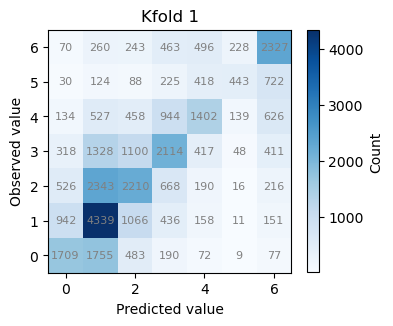

In [17]:
# Define for the figure
nrows = 1
ncols = n_kfold
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

if ncols > 1:
    fig.suptitle('Confusion matrices (per kfold)', fontsize=10)

# Set figure width relative to the number of kfolds
width = 20 * (n_kfold/5)
fig.set_size_inches(width,5)

# Legend height
shrink = 0.5

row = 0
col = 0

# Loop through the kfolds, subplot per kfold
for k in range(n_kfold):
    # Get axes
    if col > 1:
        ax = axs[col] 
    else:
        # not take row argument as that only has 1 value, so axs is 1D
        ax = axs
        
    # Set axis title
    ax.set_title(f'Kfold {k+1}')

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')
    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test, y_pred_kfold[k])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    #Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

    col += 1
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)

filename = os.path.join(paths.image_save_path, 
                       (paths.notebook + paths.model_text + 
                        '_confusion_matrices_per_kfold.jpg'))
plt.savefig(filename, dpi=300)

plt.show()

## Multiclass ROC AUC

Calculate the overall ROC AUC for multiclass classification (a value per k-fold model)

In [18]:
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)
print (f'ROCAUC (mean of {n_kfold} k-folds): {roc_auc_ovr_mean:0.3f}')
print (f'ROCAUC (std across {n_kfold} kfolds): {np.std(roc_auc_ovr_kfold):0.3f})')
print (f'ROCAUC (per kfold): {roc_auc_ovr_kfold}')

ROCAUC (mean of 1 k-folds): 0.813
ROCAUC (std across 1 kfolds): 0.000)
ROCAUC (per kfold): [0.8127902193103983]


Plot histograms for each class (for each kfold model)

Using the functions that are slightly modified from the binary classifier case.

Resources:

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb



In [19]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) 
    based on real and predicted observations
    
    Args:
        y_real [list or series]: The list or series with the real classes
        y_pred [list or series]: The list or series with the predicted classes
        
    Returns:
        tpr [float]: The True Positive Rate of the classifier
        fpr [float]: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [20]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each 
    point as a threshold for the predicion of the class.
    
    Args:
        y_real [list or series]: The list or series with the real classes.
        y_proba [array]: The array with the probabilities for each class, 
                    obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list [list]: The list of TPRs representing each threshold.
        fpr_list [list]: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [21]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr [list]: The list of TPRs representing each coordinate.
        fpr [list]: The list of FPRs representing each coordinate.
        scatter [boolean]: When True, the points used on the calculation will be 
                    plotted with the line (default = True).
        ax [object]: matplotlib ax object

    Returns:
        None
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    return ()

ROC Curve - One vs Rest (OvR)
Compares each class with the rest of the classes

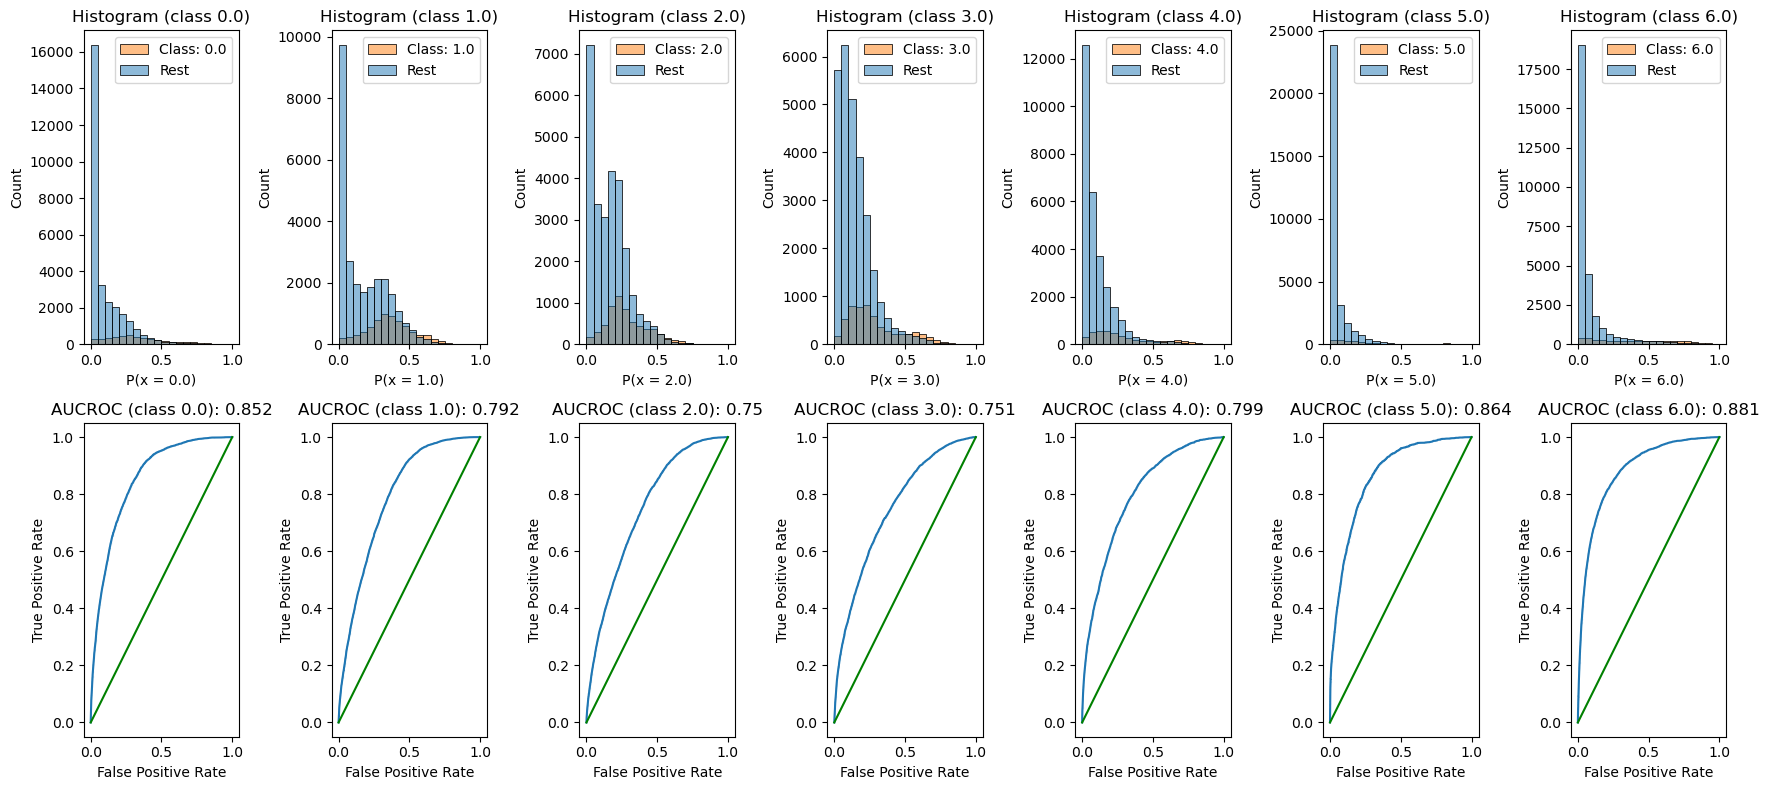

In [22]:
classes = model.classes_

bins = [i/20 for i in range(20)] + [1]

# figure width to change with number of classes
width = 15 * (len(classes)/6)

# Create a figure per kfold
for k in range(n_kfold):
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    plt.figure(figsize = (width, 8))
    fig.suptitle(f'K-fold {k}')
    roc_auc_ovr = {}

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # With a subplot for each class
    for i in range(len(classes)):

        # Gets the class
        c = classes[i]
        
        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_probs_kfold[k][:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, len(classes), i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', 
                     ax = ax, bins = bins)
        ax.set_title(f'Histogram (class {c})')
        ax.legend([f"Class: {c}", "Rest"])
        ax.set_xlabel(f"P(x = {c})")
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, len(classes), i+len(classes)+1)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title(
                    f'AUCROC (class {c}): {round(roc_auc_ovr[c],3)}')
        
    plt.tight_layout()

    # Save
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + '_rocauc_ovr_kfold_' + str(k) + '.jpg'))
    
    plt.savefig(filename, dpi=300)
    plt.show()


In [23]:
if n_kfold > 1:
    classes = model.classes_

    bins = [i/20 for i in range(20)] + [1]

    # figure width to change with number of kfolds
    width = 15 * (n_kfold/5)

    # Create a figure per class
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        
        # Plots the Probability Distributions and the ROC Curves One vs Rest
        plt.figure(figsize = (width, 8))
        fig.suptitle(f'Class {c}')
        roc_auc_ovr = {}

        # With a subplot for each kfold
        for k in range(n_kfold):
            
            # Get k fold split
            (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                            test_data_kfold[k],
                                                            'discharge_disability')
            
            # Prepares an auxiliar dataframe to help with the plots
            df_aux = pd.DataFrame()
            df_aux['class'] = [1 if y == c else 0 for y in y_test]
            df_aux['prob'] = y_probs_kfold[k][:, i]
            df_aux = df_aux.reset_index(drop = True)
            
            # Calculates the ROC AUC OvR
            roc_auc_ovr[k] = roc_auc_score(df_aux['class'], df_aux['prob'])

            # Plots the probability distribution for the class and the rest
            ax = plt.subplot(2, n_kfold, k+1)
            sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', 
                        ax = ax, bins = bins)
            ax.set_title(f'Histogram (k-fold {k+1})')
            ax.legend([f"Class: {c}", "Rest"])
            ax.set_xlabel(f"P(x = {c})")
            
            # Calculates the ROC Coordinates and plots the ROC Curves
            ax_bottom = plt.subplot(2, n_kfold, k+1+n_kfold)
            tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
            plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
            ax_bottom.set_title(
                        f'AUCROC (k-fold {k+1}): {round(roc_auc_ovr[k],3)}')
            
        plt.tight_layout()

        # Save
        filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                    f'_rocauc_ovr_class_{c}.jpg') 
        plt.savefig(filename, dpi=300)
        plt.show()
else:
    print('As this only uses one k-fold, this plot will not be created (it will'
        ' not provide any extra information over the set of subplots above)')


As this only uses one k-fold, this plot will not be created (it will not provide any extra information over the set of subplots above)


To interpret the above plots, think of the model as having 7 separate parts, each giving the probability of classifying an instance as each class (0, 1, 2, 3, 4, 5, 6).

These charts look at the performance of each of the model parts in isolation.

Left hand graph: Showing the probability of the model classifying an instance as class 0, for all of the instances that are a 0 (orange), for all the instances that are not 0 (blue). The blues are made up of the classes 1, 2, 3, 4, 5, 6.

Right hand graph: Showing the probability of the model classifying an instance as class 6, for all of the instances that are a 6 (orange), for all the instances that are not 6 (blue). The blues are made up of the classes 0, 1, 2, 3, 4, 5.

The model does not use a set threshold to determine the classification from a single graph (as in a binary label model). It instead classifies instances based on the class that has the maximum probability for that instance.

Therefore, for the LHS graph we can not know which of the instances end up getting a class 0 classification, as the threshold will differ for each instnace. So an orange point with 0.3 probability may get a 0 classification, and another orange point with 0.3 probability may not get a 0 classification.

Using ROC AUC to choose the features means we are choosing the feature which best differentiates each class from the others (a mean across all classes). It is not showing a model that has the best prediction (as it is not comparing the probabilities across the 7 classes).

The blue histogram in the OvR graphs represents the other 6 classes. When perform OvO the orange distribution is the same across all the graphs, but the blue is filtered to show just one of the other classes. Summing up all the OvR blue bits will give the OvO graph.

(see end of notebook for the OvO graphs)

## Section 1: Feature contribution (feature importance and SHAP)

### Feature Importances

Get XGBoost feature importances (average across k-fold results)

It seems that the built in feature importance is not returned per class, so analyse it in the same way as if a binary classification model
https://stackoverflow.com/questions/58603632/how-to-get-feature-importance-for-each-class-in-mutliclass-classification-with-x)

XGBoost algorithm provides a metrc per feature called "feature importance". It does not provide this value with respoect ot the output class, just a single value.

Examine the consitency of feature importances across k-fold splits.

A model is fitted to each k-fold split, and feature importance values are obtained for each model (but not for each output class). 

This next section assesses the range of feature importance values for each feature across the k-fold splits.

Create (and show) a dataframe that stores the min, median, and max feature importance value for each feature across the 5 k-fold splits

In [24]:
df_feature_importance = pd.DataFrame(index=features_ohe)

# For each k-fold
for k in range(n_kfold):
    # feature importance value for each k-fold split
    df_feature_importance[f'{k}'] = feature_importance_kfold[k]

# Calcualte descriptive stats of the feature importance (across the 5 k-folds)
# Store in DataFrame
df_feature_importance['importance (mean)'] = (
                    np.array(feature_importance_kfold).mean(axis = 0))
df_feature_importance['importance (std dev)'] = (
                    np.array(feature_importance_kfold).std(axis = 0))
df_feature_importance['importance (min)'] = (
                    np.array(feature_importance_kfold).min(axis = 0))
df_feature_importance['importance (median)'] = (
                    np.median(np.array(feature_importance_kfold),axis=0))
df_feature_importance['importance (max)'] = (
                    np.array(feature_importance_kfold).max(axis = 0))


# Sort by importance (weight)
df_feature_importance.sort_values(by='importance (median)', 
                                  ascending=False, inplace=True)

# Save
filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
            f'_feature_importance.csv')
df_feature_importance.to_csv(filename)

# Display top 25
df_feature_importance.head(25)

0  importance (mean)  \
prior_disability                          0.042477           0.042477   
team_Royal Stoke University Hospital      0.033812           0.033812   
nihss_arrival_loc                         0.033748           0.033748   
team_Salford Royal Hospital               0.022300           0.022300   
nihss_arrival_best_gaze                   0.020550           0.020550   
team_University Hospital of North Durham  0.019663           0.019663   
team_Leicester Royal Infirmary            0.016056           0.016056   
team_Sandwell District Hospital           0.015991           0.015991   
team_Royal Hallamshire Hospital           0.015534           0.015534   
team_Derriford Hospital                   0.015103           0.015103   
team_Pinderfields Hospital                0.014105           0.014105   
team_Ysbyty Gwynedd                       0.013761           0.013761   
team_Queen Alexandra Hospital Portsmouth  0.012576           0.012576   
team_University Hospital Coventry         0.012360           0.012360   
nihss_arrival_loc_questions               0.012169           0.012169   
team_Fairfield General Hospital           0.011717           0.011717   
team_Blackpool Victoria Hospital          0.011289           0.011289   
nihss_arrival_extinction_inattention      0.011227           0.011227   
team_East Surrey Hospital                 0.011117           0.011117   
team_Lister Hospital                      0.011087           0.011087   
team_Princess Royal Hospital Telford      0.010181           0.010181   
team_Cumberland Infirmary                 0.010073           0.010073   
team_Kings Mill Hospital                  0.009898           0.009898   
team_Peterborough City Hospital           0.009779           0.009779   
team_Worcestershire Royal Hospital        0.009526           0.009526   

                                          importance (std dev)  \
prior_disability                                           0.0   
team_Royal Stoke University Hospital                       0.0   
nihss_arrival_loc                                          0.0   
team_Salford Royal Hospital                                0.0   
nihss_arrival_best_gaze                                    0.0   
team_University Hospital of North Durham                   0.0   
team_Leicester Royal Infirmary                             0.0   
team_Sandwell District Hospital                            0.0   
team_Royal Hallamshire Hospital                            0.0   
team_Derriford Hospital                                    0.0   
team_Pinderfields Hospital                                 0.0   
team_Ysbyty Gwynedd                                        0.0   
team_Queen Alexandra Hospital Portsmouth                   0.0   
team_University Hospital Coventry                          0.0   
nihss_arrival_loc_questions                                0.0   
team_Fairfield General Hospital                            0.0   
team_Blackpool Victoria Hospital                           0.0   
nihss_arrival_extinction_inattention                       0.0   
team_East Surrey Hospital                                  0.0   
team_Lister Hospital                                       0.0   
team_Princess Royal Hospital Telford                       0.0   
team_Cumberland Infirmary                                  0.0   
team_Kings Mill Hospital                                   0.0   
team_Peterborough City Hospital                            0.0   
team_Worcestershire Royal Hospital                         0.0   

                                          importance (min)  \
prior_disability                                  0.042477   
team_Royal Stoke University Hospital              0.033812   
nihss_arrival_loc                                 0.033748   
team_Salford Royal Hospital                       0.022300   
nihss_arrival_best_gaze                           0.020550   
team_University Hospital of North Durham          0.019663   

Graph of % stroke team for the top n feautres

In [25]:
# Create a mask for feature names that don't contain string "team"
mask_exclude_team = ['team' not in i for i in list(df_feature_importance.index)]
mask_team = ['team' in i for i in list(df_feature_importance.index)]

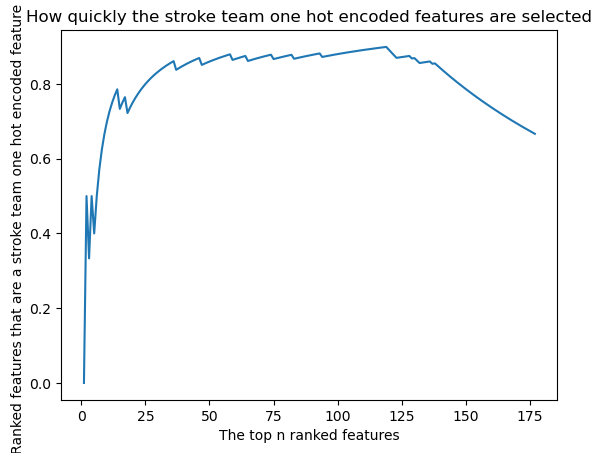

In [26]:
list_pc_team_feature = [sum(mask_team[:i+1])/(i+1) for i in range(177)]

plt.plot(list(range(1,178,1)), list_pc_team_feature)
plt.title('How quickly the stroke team one hot encoded features are selected')
plt.xlabel('The top n ranked features')
plt.ylabel('Ranked features that are a stroke team one hot encoded feature (%)')

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + 
                    'percent_team_ohe_features_ranked_importance.jpg'))
plt.savefig(filename, dpi=300)

In [27]:
# Use a mask for feature names that don't contain string "team"
df_feature_importance[mask_exclude_team].head(25)

0  importance (mean)  \
prior_disability                      0.042477           0.042477   
nihss_arrival_loc                     0.033748           0.033748   
nihss_arrival_best_gaze               0.020550           0.020550   
nihss_arrival_loc_questions           0.012169           0.012169   
nihss_arrival_extinction_inattention  0.011227           0.011227   
nihss_arrival_motor_arm_left          0.007779           0.007779   
nihss_arrival_motor_arm_right         0.007038           0.007038   
nihss_arrival_loc_commands            0.006166           0.006166   
age                                   0.005723           0.005723   
nihss_arrival_motor_leg_left          0.005238           0.005238   
nihss_arrival_motor_leg_right         0.004945           0.004945   
nihss_arrival_best_language           0.004664           0.004664   
nihss_arrival_visual                  0.003309           0.003309   
nihss_arrival_dysarthria              0.003299           0.003299   
nihss_arrival_facial_palsy            0.003262           0.003262   
onset_to_thrombolysis_time            0.003237           0.003237   
any_afib_diagnosis                    0.002995           0.002995   
precise_onset_known                   0.002915           0.002915   
nihss_arrival_limb_ataxia             0.002909           0.002909   
nihss_arrival_sensory                 0.002327           0.002327   

                                      importance (std dev)  importance (min)  \
prior_disability                                       0.0          0.042477   
nihss_arrival_loc                                      0.0          0.033748   
nihss_arrival_best_gaze                                0.0          0.020550   
nihss_arrival_loc_questions                            0.0          0.012169   
nihss_arrival_extinction_inattention                   0.0          0.011227   
nihss_arrival_motor_arm_left                           0.0          0.007779   
nihss_arrival_motor_arm_right                          0.0          0.007038   
nihss_arrival_loc_commands                             0.0          0.006166   
age                                                    0.0          0.005723   
nihss_arrival_motor_leg_left                           0.0          0.005238   
nihss_arrival_motor_leg_right                          0.0          0.004945   
nihss_arrival_best_language                            0.0          0.004664   
nihss_arrival_visual                                   0.0          0.003309   
nihss_arrival_dysarthria                               0.0          0.003299   
nihss_arrival_facial_palsy                             0.0          0.003262   
onset_to_thrombolysis_time                             0.0          0.003237   
any_afib_diagnosis                                     0.0          0.002995   
precise_onset_known                                    0.0          0.002915   
nihss_arrival_limb_ataxia                              0.0          0.002909   
nihss_arrival_sensory                                  0.0          0.002327   

                                      importance (median)  importance (max)  
prior_disability                                 0.042477          0.042477  
nihss_arrival_loc                                0.033748          0.033748  
nihss_arrival_best_gaze                          0.020550          0.020550  
nihss_arrival_loc_questions                      0.012169          0.012169  
nihss_arrival_extinction_inattention             0.011227          0.011227  
nihss_arrival_motor_arm_left                     0.007779          0.007779  
nihss_arrival_motor_arm_right                    0.007038          0.007038  
nihss_arrival_loc_commands                       0.006166          0.006166  
age                                              0.005723          0.005723  
nihss_arrival_motor_leg_left                     0.005238          0.005238  
nihss_arrival_motor_leg_right                    0.00494

Create a bar chart for the XGBoost feature importance values
(create one excluding the stroke team one hot encoded features)

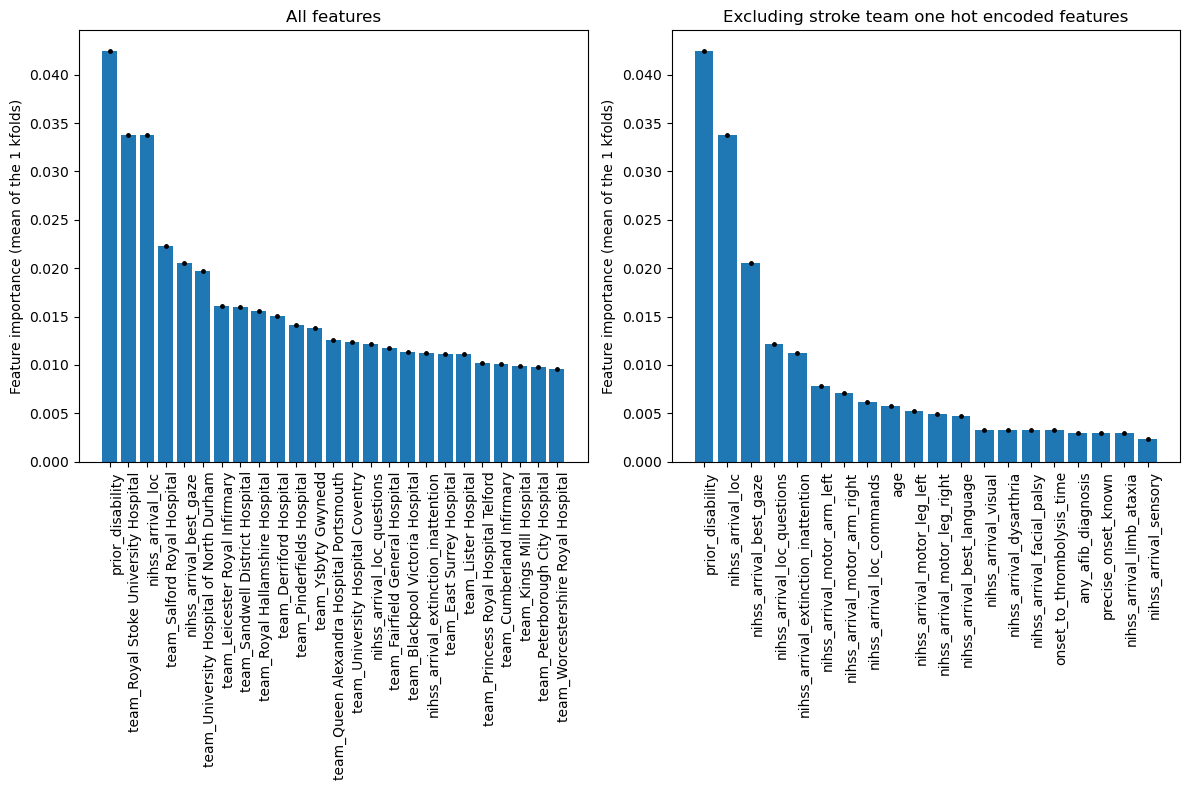

In [28]:
# Set up figure
fig = plt.figure(figsize=(12,8))

# Set up list of masks.
# First mask includes all features. Second mask excludes stroke team ohe
list_mask = [[True] * n_features, mask_exclude_team]
list_title = ['All features', 'Excluding stroke team one hot encoded features']

# Set up two subplots
for subplot in range(2):
    ax = fig.add_subplot(1,2,subplot+1)

    # Get labels and values
    labels = df_feature_importance[list_mask[subplot]].index.values[0:25]
    pos = np.arange(len(labels))
    val = df_feature_importance['importance (mean)'][list_mask[subplot]].values[0:25]
    std = df_feature_importance['importance (std dev)'][list_mask[subplot]].values[0:25]

    # Plot
    ax.bar(pos, val)
    ax.set_ylabel(f'Feature importance (mean of the {n_kfold} kfolds)')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_title(list_title[subplot])

    # Add error bars (standard deviation)
    plt.errorbar(pos, val, yerr=std, color="k", ls='none', marker='o', markersize=2.5)# fmt='.k')#, fmt="o"

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
            rotation_mode="anchor")

plt.tight_layout()

# Save figure
filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + 'feature_weights_bar.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

Create a violin plot for these 10 features with the highest feature importance values.

A violin plot shows the distribution of the feature importance values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

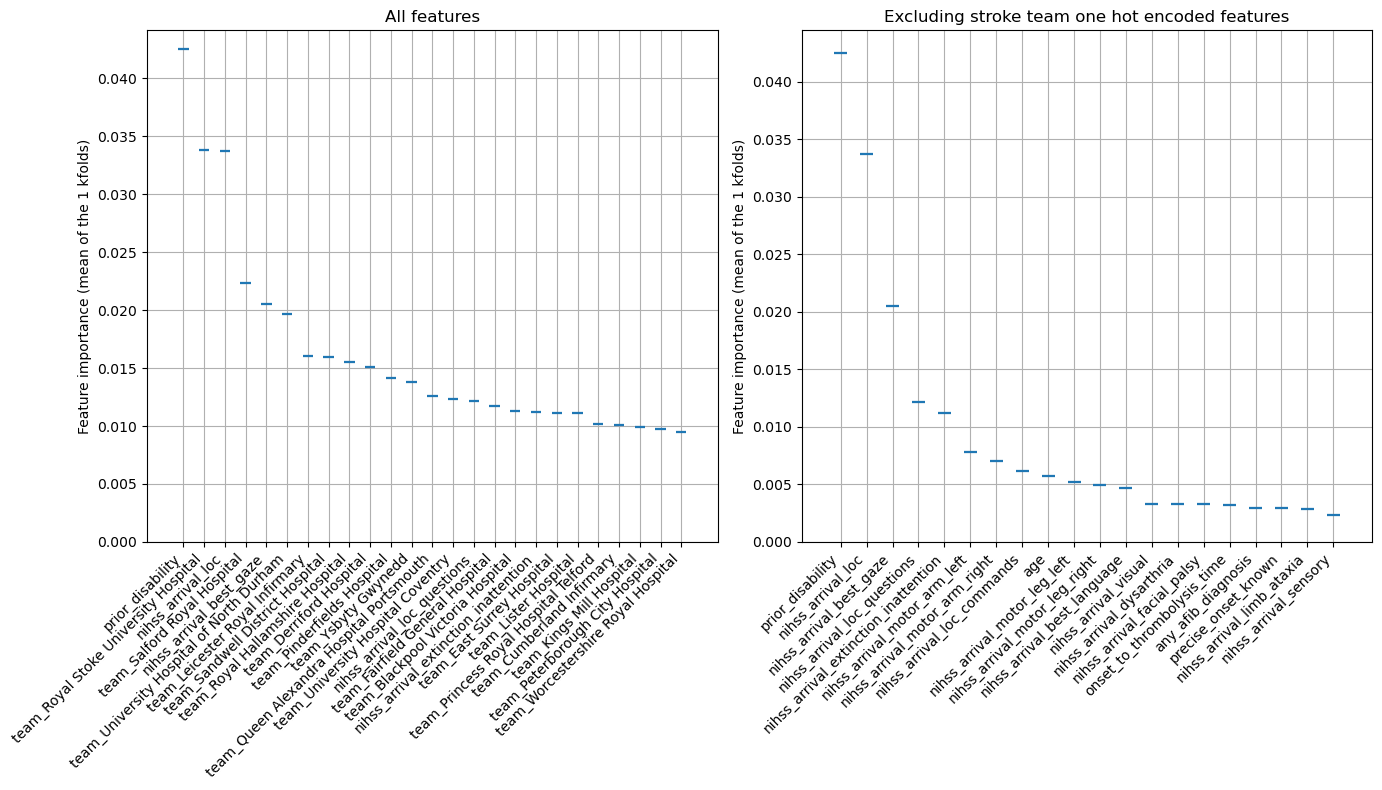

In [29]:
# Set up figure
fig = plt.figure(figsize=(14,8))

n_features_show = 25

# Create list of kfold indices
cols = [str(i) for i in range(n_kfold)]

# Set up first mask to include all features, and second mask to exclude stroke team
list_mask = [[True] * n_features, mask_exclude_team]
list_title = ['All features', 'Excluding stroke team one hot encoded features']

for subplot in range(2):
    features_show = list(df_feature_importance[list_mask[subplot]].head(n_features_show).index)

    ax1 = fig.add_subplot(1,2,subplot+1)

    ax1.violinplot(df_feature_importance[cols].loc[features_show].T,
                showmedians=True,
                widths=1)
    ax1.set_ylim(0)
    ax1.set_xticks(np.arange(1, len(features_show) + 1))
    ax1.set_xticklabels(features_show, rotation=45, ha='right')
    ax1.grid(which='both')
    ax1.set_ylabel(f'Feature importance (mean of the {n_kfold} kfolds)')
    ax1.set_title(list_title[subplot])

plt.tight_layout()

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + 'importance_violin.jpg'))

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


### SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [30]:
# Initialise empty lists
shap_values_extended_kfold = []
shap_values_kfold = []

# For each k-fold split
for k in range(n_kfold):
    # Set filename
    filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                f'_shap_values_extended_{k}.p')
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            shap_values_extended_kfold.append(shap_values_extended)
            shap_values_kfold.append(shap_values_extended.values)
    else:
        # Calculate SHAP values
        # Get k fold split
        train = train_data_kfold[k]
        test = test_data_kfold[k]

        # Get X and y
        X_train = train.drop('discharge_disability', axis=1)
        X_test = test.drop('discharge_disability', axis=1)
        y_train = train['discharge_disability']
        y_test = test['discharge_disability']

        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model_kfold[k], X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
        shap_values_extended_kfold.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        shap_values_kfold.append(shap_values)        

        explainer_filename = (f'{paths.output_save_path}{paths.notebook}_'
                              f'{paths.model_text}_shap_explainer_{k}.p')

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    # Print progress
    print (f'Completed {k+1} of {n_kfold}')

100%|===================| 235594/235690 [22:02<00:00]        

Completed 1 of 1


#### Get average SHAP values for each k-fold

For each k-fold split, calculate the mean SHAP value for each feature (across all instances), for each of the 7 disability discharge output values. 

The mean is calculated in three ways:

1. mean of raw values
2. mean of absolute values
3. absolute of mean of raw values


In a separate dataframe (df_mean_abs_shap), store the mean of the absolute SHAP values for each kfold, and also the min, median and max across the 5 kfolds (a row per feature). A dataframe per output class.

In [31]:

# Initialise dictionary. Key name is output_class. Holds a list for dataframes
# for that class (for each kfold). The dataframe has a row per feature and a 
# column for the average SHAP values across all of the instances
dict_mean_abs_shap = {}
dict_list_of_df = {}

# For each output class
for c in range(n_classes):

    ## Initialise empty lists
    shap_values_mean_kfold = []
    # Initialise DataFrame (stores mean of the absolute SHAP values for each kfold)
    df_mean_abs_shap = pd.DataFrame()

    # For each k-fold split
    for k in range(n_kfold):
        # Calculate mean SHAP value for each feature (across all instances), for
        # this class
        shap_values = shap_values_kfold[k][:,:,c]
        df = pd.DataFrame(index=features_ohe)
        df['mean_shap'] = np.mean(shap_values, axis=0)
        df['abs_mean_shap'] = np.abs(df['mean_shap'])
        df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
        df['rank'] = df['mean_abs_shap'].rank(ascending=False).values
        df.sort_index()
        shap_values_mean_kfold.append(df)

        # Store the mean of the absolute SHAP values in a dataframe (column for 
        # each k-fold split). 
        # Add more columns to this dataframe
        df_mean_abs_shap[f'{k}'] = df['mean_abs_shap']

    # For this class, df_mean_abs_shap has a column per kfold, row per feature, 
    # stores the mean of the absolute SHAP values across all instances.
    # Dictionary has a keyname per class, each storing a list of dataframes 
    # (a dataframe per kfold)
    dict_list_of_df[f'class{c}'] = shap_values_mean_kfold

    # Dictionary has a keyname per class, each storing a dataframe with a column 
    # per kfold (the mean of the absolute SHAPS across the instances). 

    # Create list of kfold indices
    cols = [str(i) for i in range(n_kfold)]

    df_mean_abs_shap['min'] = df_mean_abs_shap[cols].min(axis=1)
    df_mean_abs_shap['median'] = df_mean_abs_shap[cols].median(axis=1) 
    df_mean_abs_shap['max'] = df_mean_abs_shap[cols].max(axis=1)
    # Order features by their median value of the mean across the instances of their absolute SHAP
    df_mean_abs_shap.sort_values('median', inplace=True, ascending=False)


    # The 3 columns (min, median, max) that were in df_mean_abs_shap_summary are now in df_mean_abs_shap
    # Store the dataframe for this class (row per feature, column per kfold (and summary statistics) for SHAPs across all instances)
    dict_mean_abs_shap[f'class{c}'] = df_mean_abs_shap

For each output class, identify the 10 features with the highest SHAP values (in terms of the median of the kfolds of the mean of the absolute SHAP values)

Create a violin plot for these 10 features with the highest SHAP values.

A violin plot shows the distribution of the SHAP values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

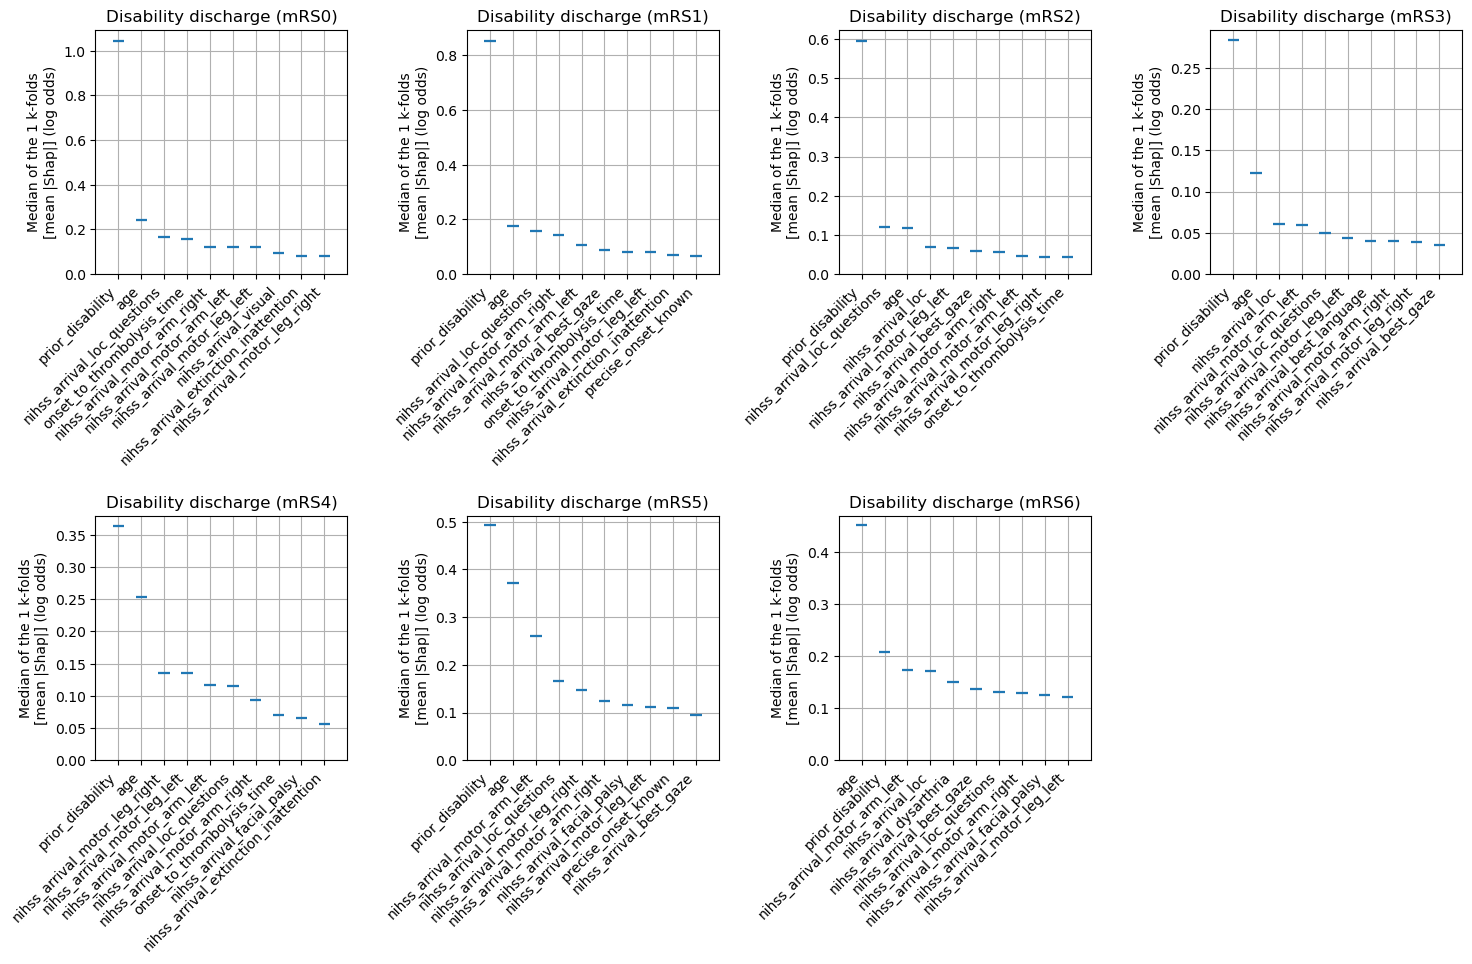

In [32]:
fig = plt.figure(figsize=(15, 10))

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']

    # Create list of kfold indices
    cols = [str(i) for i in range(n_kfold)]

    ax1 = fig.add_subplot(2,4,c+1)
    ax1.violinplot(df_mean_abs_shap[cols].iloc[:10].T,
                showmedians=True, widths=1)
    ax1.set_ylim(0)
    ax1.set_title(f'Disability discharge (mRS{c})')
    labels = df_mean_abs_shap.index[:10]
    ax1.set_xticks(np.arange(1, len(labels) + 1))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(which='both')
    ax1.set_ylabel(f'Median of the {n_kfold} k-folds\n[mean |Shap|] (log odds)')

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + '_shap_violin.jpg'))

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Compare top 10 SHAP and feature importance values

Compare the features (and their values) that make the top 10 when selected by either SHAP values, or feature importance values

In [33]:
df_compare_shap_importance = pd.DataFrame()
df_compare_shap_importance['Importance (feature name)'] = \
                            df_feature_importance.index
df_compare_shap_importance['Importance (median value)'] = \
                            df_feature_importance['importance (median)'].values

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_compare_shap_importance[f'SHAP (feature name) [mRS{c}]'] = dict_mean_abs_shap[f'class{c}'].index
    df_compare_shap_importance[f'SHAP (median value) [mRS{c}]'] = dict_mean_abs_shap[f'class{c}']['median'].values
               
df_compare_shap_importance.head(10)

Importance (feature name)  Importance (median value)  \
0                          prior_disability                   0.042477   
1      team_Royal Stoke University Hospital                   0.033812   
2                         nihss_arrival_loc                   0.033748   
3               team_Salford Royal Hospital                   0.022300   
4                   nihss_arrival_best_gaze                   0.020550   
5  team_University Hospital of North Durham                   0.019663   
6            team_Leicester Royal Infirmary                   0.016056   
7           team_Sandwell District Hospital                   0.015991   
8           team_Royal Hallamshire Hospital                   0.015534   
9                   team_Derriford Hospital                   0.015103   

             SHAP (feature name) [mRS0]  SHAP (median value) [mRS0]  \
0                      prior_disability                    1.044396   
1                                   age                    0.242680   
2           nihss_arrival_loc_questions                    0.164955   
3            onset_to_thrombolysis_time                    0.156181   
4         nihss_arrival_motor_arm_right                    0.122825   
5          nihss_arrival_motor_arm_left                    0.122492   
6          nihss_arrival_motor_leg_left                    0.121308   
7                  nihss_arrival_visual                    0.094952   
8  nihss_arrival_extinction_inattention                    0.082458   
9         nihss_arrival_motor_leg_right                    0.080028   

             SHAP (feature name) [mRS1]  SHAP (median value) [mRS1]  \
0                      prior_disability                    0.853010   
1                                   age                    0.174296   
2           nihss_arrival_loc_questions                    0.158474   
3         nihss_arrival_motor_arm_right                    0.142019   
4          nihss_arrival_motor_arm_left                    0.106752   
5               nihss_arrival_best_gaze                    0.086587   
6            onset_to_thrombolysis_time                    0.080444   
7          nihss_arrival_motor_leg_left                    0.080423   
8  nihss_arrival_extinction_inattention                    0.069760   
9                   precise_onset_known                    0.066739   

      SHAP (feature name) [mRS2]  SHAP (median value) [mRS2]  \
0               prior_disability                    0.595415   
1    nihss_arrival_loc_questions                    0.121094   
2                            age                    0.116882   
3              nihss_arrival_loc                    0.068787   
4   nihss_arrival_motor_leg_left                    0.067639   
5        nihss_arrival_best_gaze                    0.059590   
6  nihss_arrival_motor_arm_right                    0.056509   
7   nihss_arrival_motor_arm_left                    0.047425   
8  nihss_arrival_motor_leg_right                    0.044027   
9     onset_to_thrombolysis_time                    0.042588   

      SHAP (feature name) [mRS3]  SHAP (median value) [mRS3]  \
0               prior_disability                    0.283222   
1                            age                    0.121980   
2              nihss_arrival_loc                    0.061232   
3   nihss_arrival_motor_arm_left                    0.058988   
4    nihss_arrival_loc_questions                    0.049267   
5   nihss_arrival_motor_leg_left                    0.043917   
6    nihss_arrival_best_language                    0.040547   
7  nihss_arrival_motor_arm_right                    0.040093   
8  nihss_arrival_motor_leg_right                    0.038335   
9        nihss_arrival_best_gaze                    0.035791   

             SHAP (feature name) [mRS4]  SHAP (median value) [mRS4]  \
0                      prior_disability                    0.363920   
1                                   age                    0.253109   
2         nihss_

Plot all of the features, showing feature importance vs SHAP values.

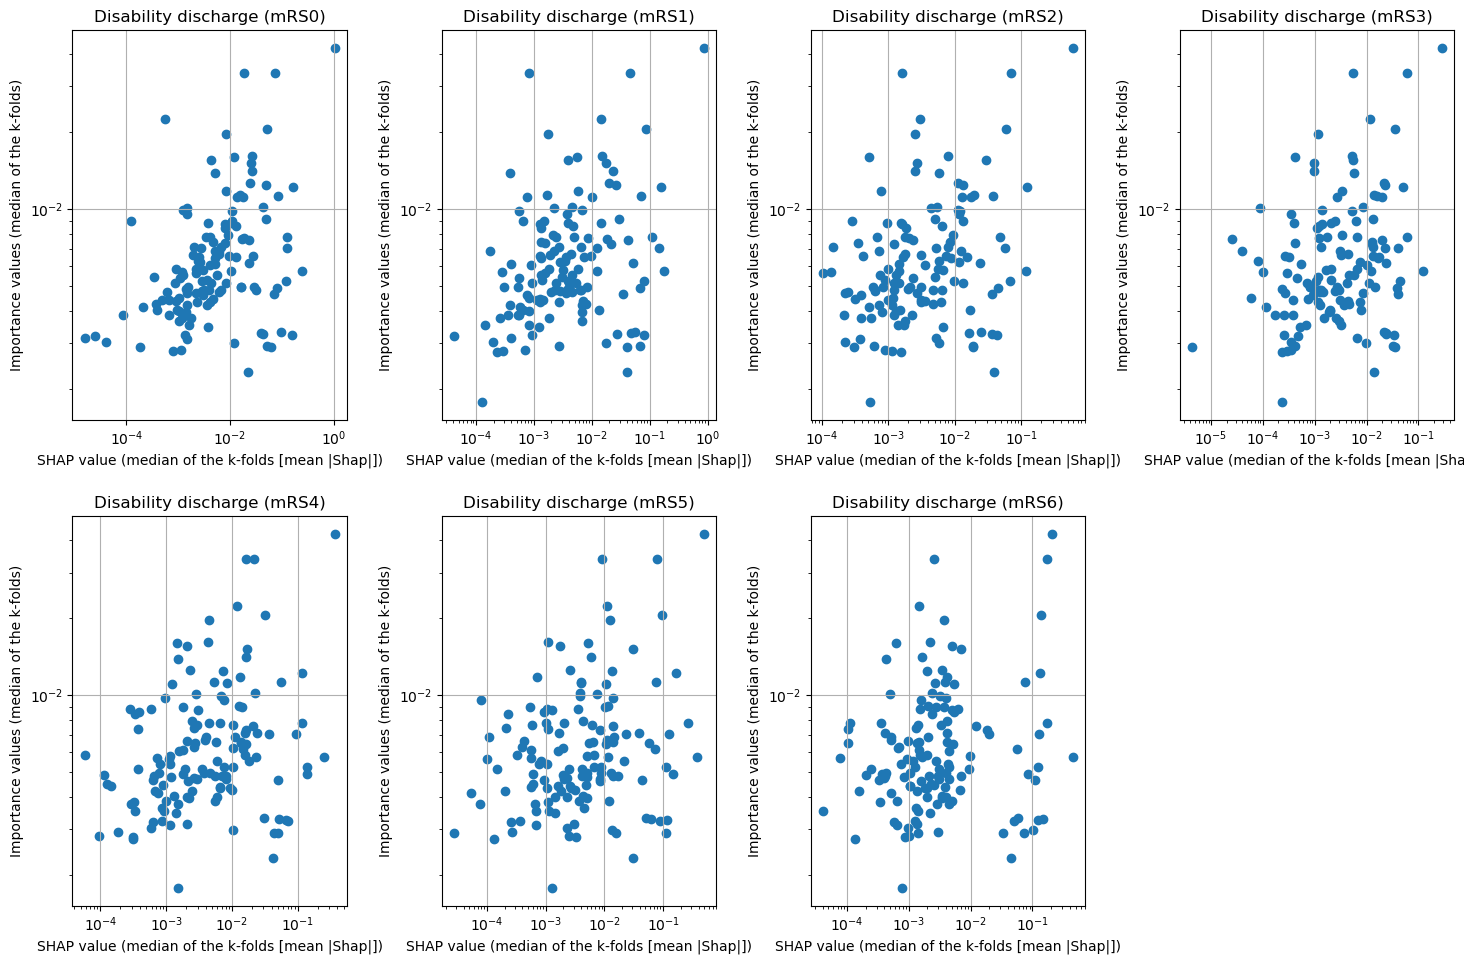

In [34]:
fig = plt.figure(figsize=(15, 10))

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']
    

    df_shap_importance = pd.DataFrame()
    df_shap_importance['Shap'] =  df_mean_abs_shap['median']
    df_shap_importance = df_shap_importance.merge(
        df_feature_importance['importance (median)'], left_index=True, right_index=True)
    df_shap_importance.rename(columns={'importance (median)': 'Importance'}, inplace=True)
    df_shap_importance.sort_values('Shap', inplace=True, ascending=False)

    ax1 = fig.add_subplot(2,4,c+1)
    ax1.scatter(df_shap_importance['Shap'],
                df_shap_importance['Importance'])
    ax1.set_title(f'Disability discharge (mRS{c})')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('SHAP value (median of the k-folds [mean |Shap|])')
    ax1.set_ylabel('Importance values (median of the k-folds)')
    ax1.grid()
plt.subplots_adjust(bottom=0.25, wspace=0.05)

plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + 'shap_importance_correlation.jpg'))

plt.savefig(filename, dpi=300)
plt.show()


In [35]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

Time taken: 1910.7725143432617


## Section 2: Calibration and assessment of accuracy when model has high confidence.

To test for callibration. Look at each output classification separately, take all of the instances and group them based on the probability for that classification as given by the model. See how many are that classification. For all of the instances that the model gives a probability in the range 0.2 to 0.3, in a well callibrated model between 0.2 to 0.3 of these instances would be this category). 

Need to get the probability for the true category per instance.

# KP HERE
# CHECK WHAT THE DATAFRAMES RELIABILITY_SUMMARY AND RELIABILITY_CONFIDENCE HOLD?

In [36]:
def plot_results(reliability_collated, c, ax, title_text=""):
    """
    reliability_collated (dataframe): Contains 3 columns per bin
    c (string): The classification category (used in the plot title)
    ax (matplotlib axis object):  
    """

    # Loop through k-fold reliability results
    for k in range(n_kfold):
        # Get values for the kfold
        mask = reliability_collated['k-fold'] == k
        result_kfold = reliability_collated[mask]
        # Plot the confidence vs fraction positive
        x = result_kfold['confidence']
        y = result_kfold['fraction_positive']
        ax.plot(x,y, color='orange')

    # Add 1:1 line
    ax.plot([0,1],[0,1], color='k', linestyle ='--')

    # Refine plot
    ax.set_xlabel('Model probability')
    ax.set_ylabel('Fraction positive')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Predicting mRS{round(c)}\n{title_text}')

    return(ax)

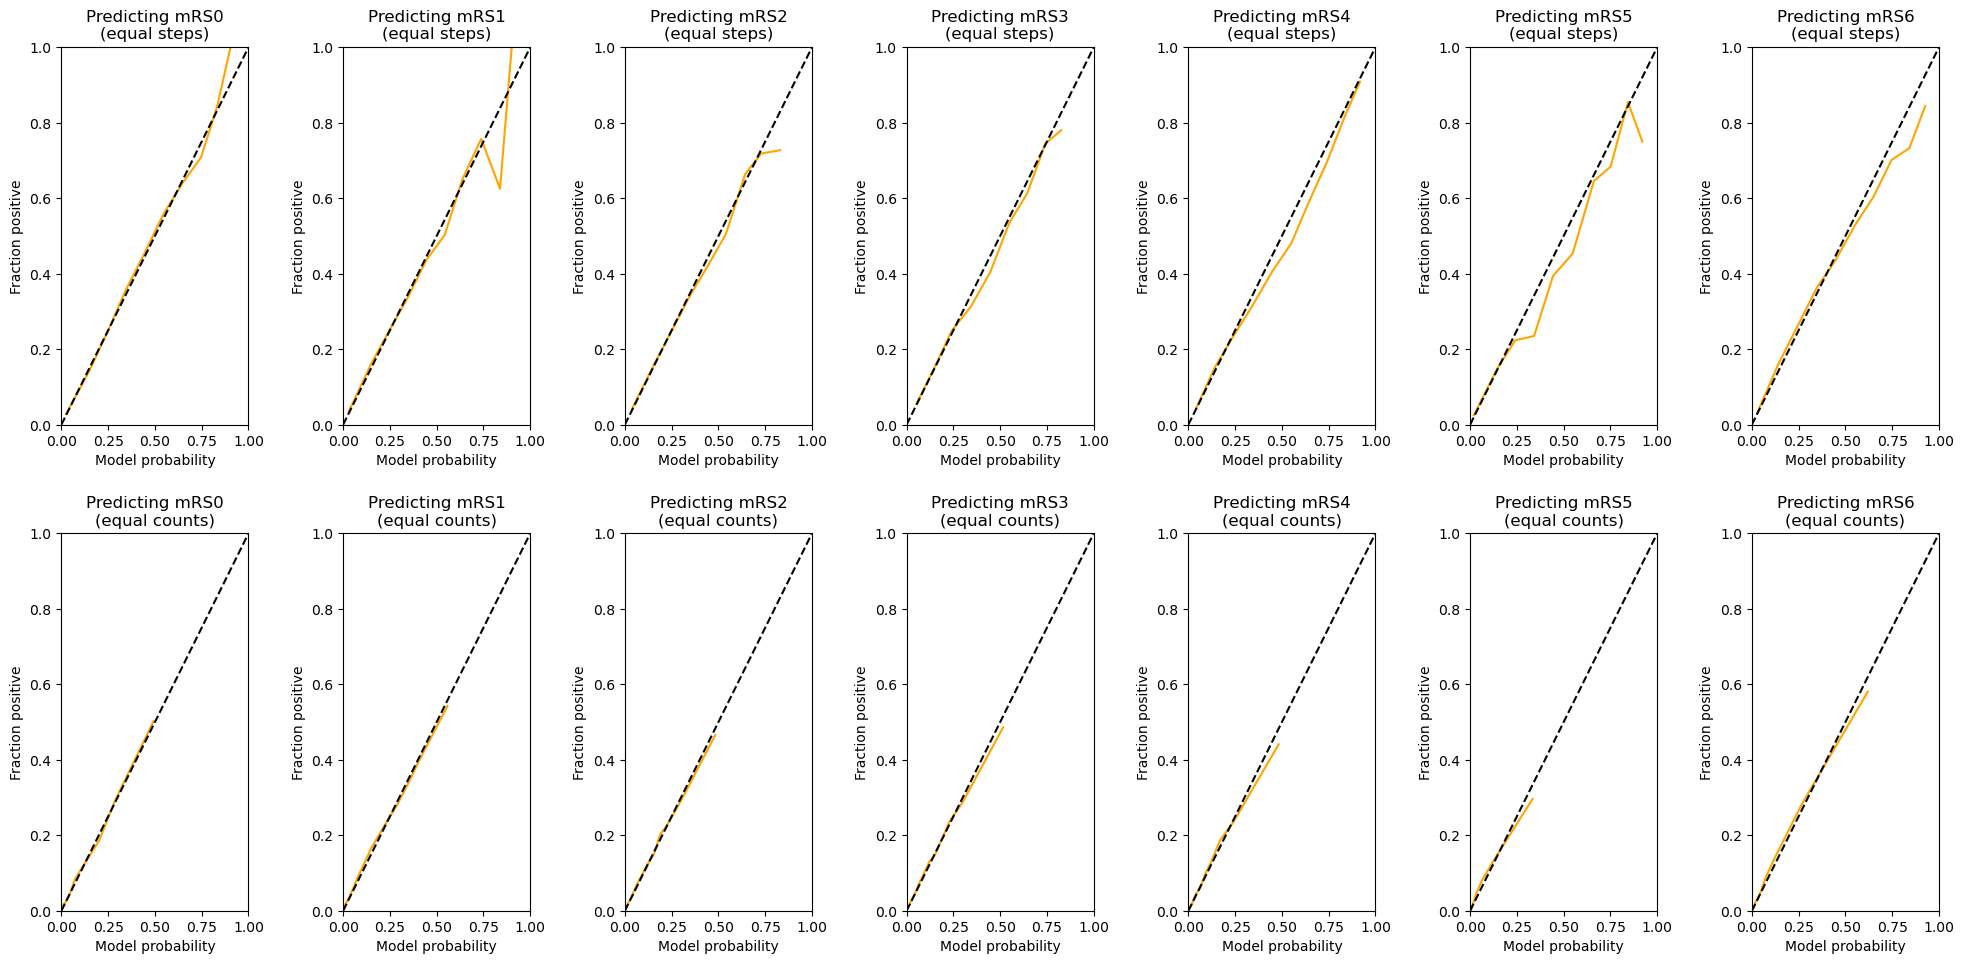

In [37]:
# Setup dictionary to store dataframes of results
dict_results = dict()

fig = plt.figure(figsize=(20,10))

col = 0
subplot = 0
for bin_method in ['steps', 'counts']:
    col = 0
    for c in class_names:
        # Collate results for each class in a Dataframe
        reliability_collated = pd.DataFrame()

        # Loop through k fold predictions
        for k in range(n_kfold):

            # Get data for this k fold split
            train = train_data_kfold[k]
            test = test_data_kfold[k]

            # Get X and y
            X_train = train.drop('discharge_disability', axis=1)
            X_test = test.drop('discharge_disability', axis=1)
            y_train = train['discharge_disability']
            y_test = test['discharge_disability']

            # Get observed class
            observed = y_test
            # And convert to binary for this class (1 = in class, 0 = rest)
            observed_binary = observed == c
    
            # Probability for current class and kfold, for all instances
            prob_observed = y_probs_kfold[k][:,col]
            # Determine the models classification of each instance
            classification = np.argmax(y_probs_kfold[k], axis=1)
    #       classification = 1 * (prob_observed > 0.5 )
            
            if bin_method == 'steps':
                # Bin data with numpy digitize (this will assign a bin to each instance 
                # based on the probability assigned by the model)
                # Create bins with equal steps
                step = 0.10
                bins = np.arange(step, 1+step, step)
                digitized = np.digitize(prob_observed, bins)
            elif bin_method == 'counts':
                # Create bins with equal counts (ensure a good number of instances in each bin)
                (res, bins) = pd.qcut(prob_observed, q=10, retbins=True)
                digitized = np.digitize(prob_observed, bins)

            # Put single fold data in DataFrame
            reliability = pd.DataFrame()
            reliability['bin'] = digitized
            reliability['probability_observed'] = prob_observed
            reliability['observed'] = observed_binary
            reliability['classification'] = classification
            reliability['correct'] = observed == classification
            reliability['count'] = 1
            reliability['class'] = c

            # Summarise data by bin in new dataframe
            reliability_summary = pd.DataFrame()

            # Add bins and k-fold to summary
            reliability_summary['bin'] = bins
            reliability_summary['bin_nominal'] = np.array(range(len(bins)))
            reliability_summary['k-fold'] = k

            # Calculate mean of predicted probability of correct category in each bin
            reliability_summary['confidence'] = \
                reliability.groupby('bin').mean()['probability_observed']

            # Calculate the proportion of patients in this class
            reliability_summary[f'fraction_positive'] = \
                reliability.groupby('bin').mean()['observed']

            # Calculate proportion correct in each bin
            reliability_summary['fraction_correct'] = \
                reliability.groupby('bin').mean()['correct']

            # Calculate fraction of results in each bin
            reliability_summary['fraction_results'] = \
                reliability.groupby('bin').sum()['count'] / reliability.shape[0]

            # Add k-fold results to DataFrame collation
            reliability_collated = reliability_collated.append(reliability_summary)

        # Get probability from next column (for next class)
        col += 1
        subplot += 1

        # Get mean results
        reliability_summary = reliability_collated.groupby('bin').mean()
        reliability_summary.drop('k-fold', axis=1, inplace=True)
    
        # Plot predicted prob vs fraction psotive
        ax = fig.add_subplot(2,n_classes,subplot)

        plot_results(reliability_collated, c, ax, f"(equal {bin_method})")

        plt.tight_layout(pad=2)

        # Store in dictionary
        dict_results[f'reliability_collated_{bin_method}_{c}'] = (
                                                        reliability_collated)
        dict_results[f'reliability_summary_{bin_method}_{c}'] = (
                                                        reliability_summary)

In [38]:
reliability_summary

bin_nominal  confidence  fraction_positive  fraction_correct  \
bin                                                                      
0.000340          0.0         NaN                NaN               NaN   
0.005642          1.0    0.003606           0.003861          0.501337   
0.010078          2.0    0.007814           0.006237          0.465993   
0.015910          3.0    0.012860           0.011286          0.428868   
0.024070          4.0    0.019707           0.024651          0.414612   
0.036129          5.0    0.029673           0.028809          0.410454   
0.055893          6.0    0.045184           0.047223          0.410454   
0.089879          7.0    0.070779           0.084645          0.412830   
0.170579          8.0    0.123623           0.141372          0.373329   
0.406469          9.0    0.269545           0.284823          0.321057   
0.973306         10.0    0.619945           0.580808          0.580511   

          fraction_results  
bin                         
0.000340               NaN  
0.005642           0.10000  
0.010078           0.10000  
0.015910           0.10000  
0.024070           0.10000  
0.036129           0.10000  
0.055893           0.10000  
0.089879           0.10000  
0.170579           0.10000  
0.406469           0.10000  
0.973306           0.09997

In [39]:
reliability_collated

bin  bin_nominal  k-fold  confidence  fraction_positive  \
0   0.000340            0       0         NaN                NaN   
1   0.005642            1       0    0.003606           0.003861   
2   0.010078            2       0    0.007814           0.006237   
3   0.015910            3       0    0.012860           0.011286   
4   0.024070            4       0    0.019707           0.024651   
5   0.036129            5       0    0.029673           0.028809   
6   0.055893            6       0    0.045184           0.047223   
7   0.089879            7       0    0.070779           0.084645   
8   0.170579            8       0    0.123623           0.141372   
9   0.406469            9       0    0.269545           0.284823   
10  0.973306           10       0    0.619945           0.580808   

    fraction_correct  fraction_results  
0                NaN               NaN  
1           0.501337           0.10000  
2           0.465993           0.10000  
3           0.428868           0.10000  
4           0.414612           0.10000  
5           0.410454           0.10000  
6           0.410454           0.10000  
7           0.412830           0.10000  
8           0.373329           0.10000  
9           0.321057           0.10000  
10          0.580511           0.09997

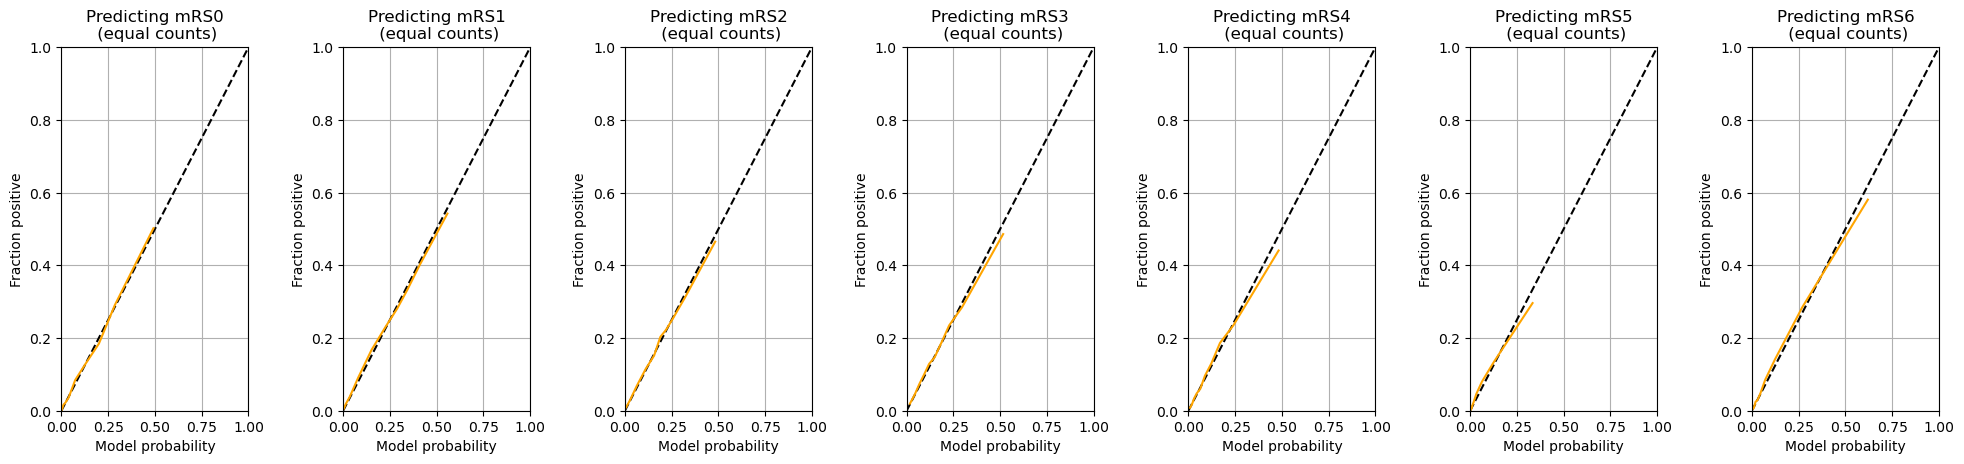

In [40]:
fig = plt.figure(figsize=(20,5))

col = 1

for c in class_names:
#    reliability_collated = dict_results[f'reliability_collated_count_{c}']
    reliability_summary = dict_results[f'reliability_summary_counts_{c}']
    # Calculate mean and standard error across the 5 kfolds in new dataframe
    reliability_overview = pd.DataFrame()

    reliability_overview['confidence_mean'] = \
        reliability_summary.groupby('bin_nominal').mean()['confidence']

    reliability_overview['confidence_stddev'] = \
        reliability_summary.groupby('bin_nominal').std()['confidence']

    reliability_overview['confidence_stderr'] = \
        reliability_overview['confidence_stddev']/math.sqrt(n_kfold)

    reliability_overview['fraction_positive_mean'] = \
        reliability_summary.groupby('bin_nominal').mean()['fraction_positive']

    reliability_overview['fraction_positive_stddev'] = \
        reliability_summary.groupby('bin_nominal').std()['fraction_positive']

    reliability_overview['fraction_positive_stderr'] = \
        reliability_overview['fraction_positive_stddev']/math.sqrt(n_kfold)

    x = reliability_overview['confidence_mean']
    y = reliability_overview['fraction_positive_mean']
    xerr = reliability_overview['confidence_stderr']
    yerr = reliability_overview['fraction_positive_stderr']

    # Plot predicted prob vs fraction psotive
    ax1 = fig.add_subplot(1,n_classes,col)

#    ax1.plot(x,y, color='orange')
    ax1.errorbar(x, y, yerr=yerr, xerr=xerr, color='orange')
    # Add 1:1 line
    ax1.plot([0,1],[0,1], color='k', linestyle ='--')
    # Refine plot
    ax1.set_xlabel('Model probability')
    ax1.set_ylabel('Fraction positive')
    ax1.set_title(f'Predicting mRS{round(c)}\n (equal counts)')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    ax1.grid()

    col += 1
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + 'reliability.jpg'))
    plt.savefig(filename, dpi=300)

plt.tight_layout(pad=2)


Calculate reliability, and plot alongside the calibration results for each class (using bins as defined as 1. equal steps 2. equal counts)

Results for class 0.0


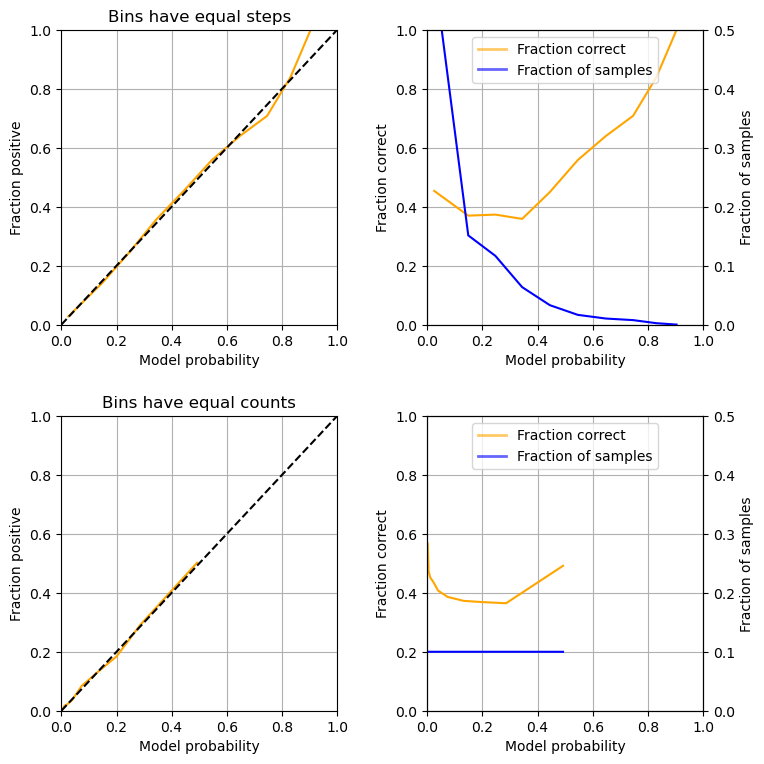

Results for class 1.0


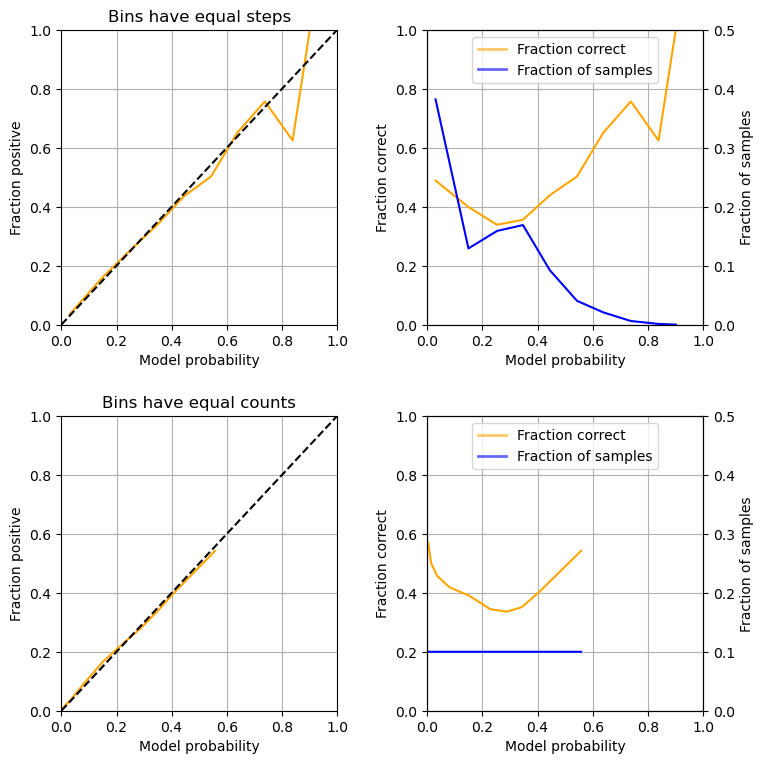

Results for class 2.0


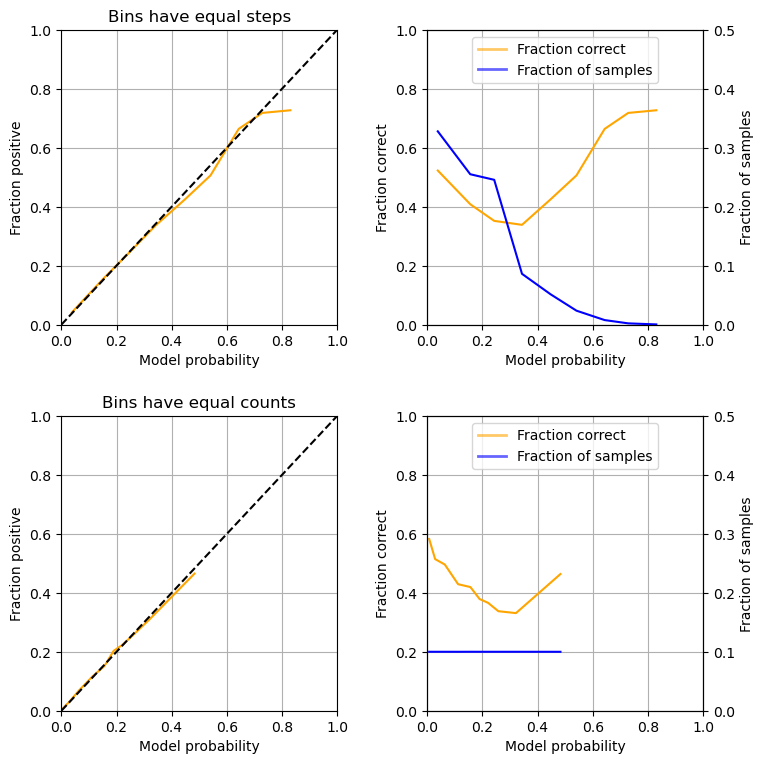

Results for class 3.0


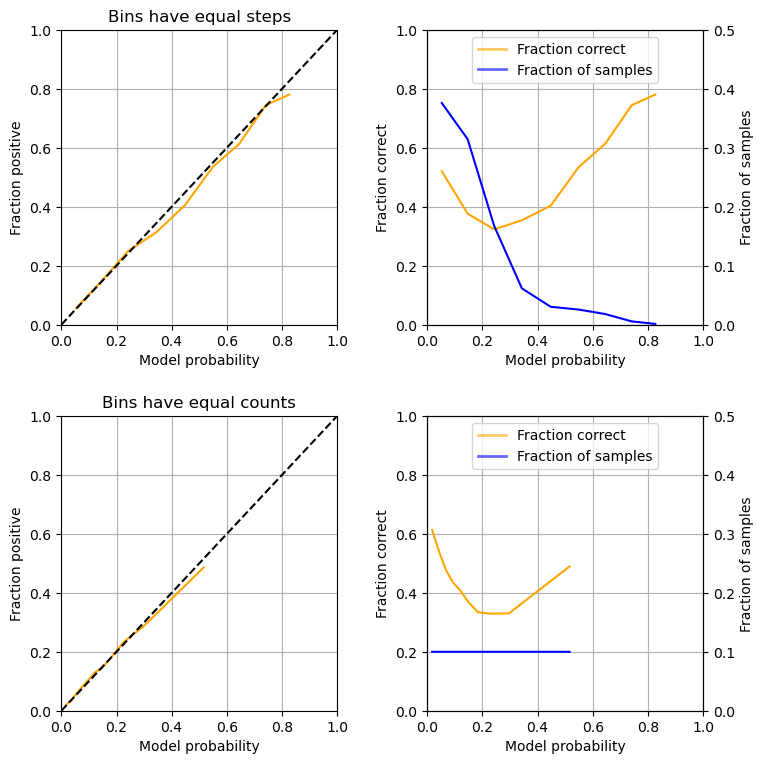

Results for class 4.0


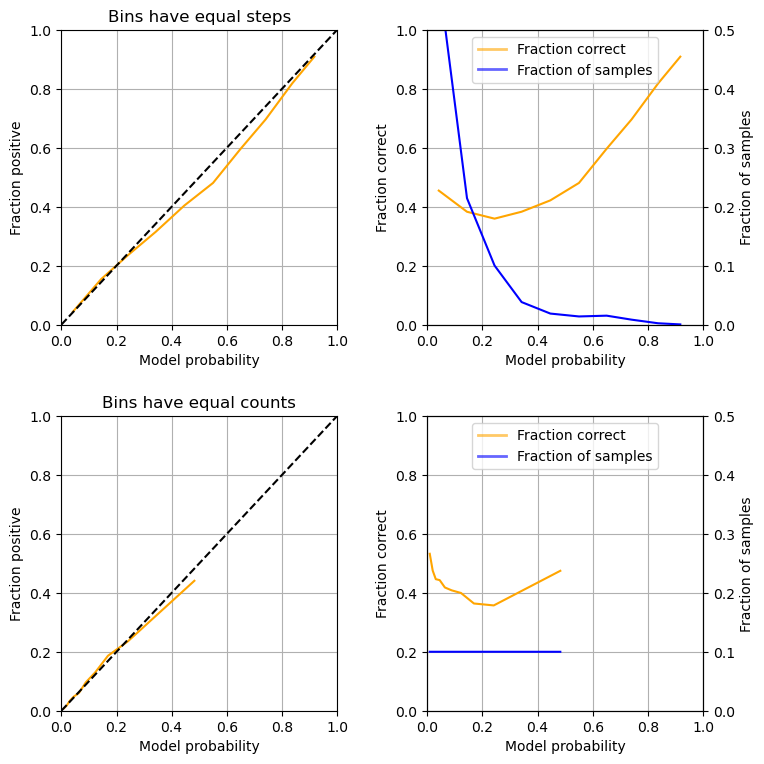

Results for class 5.0


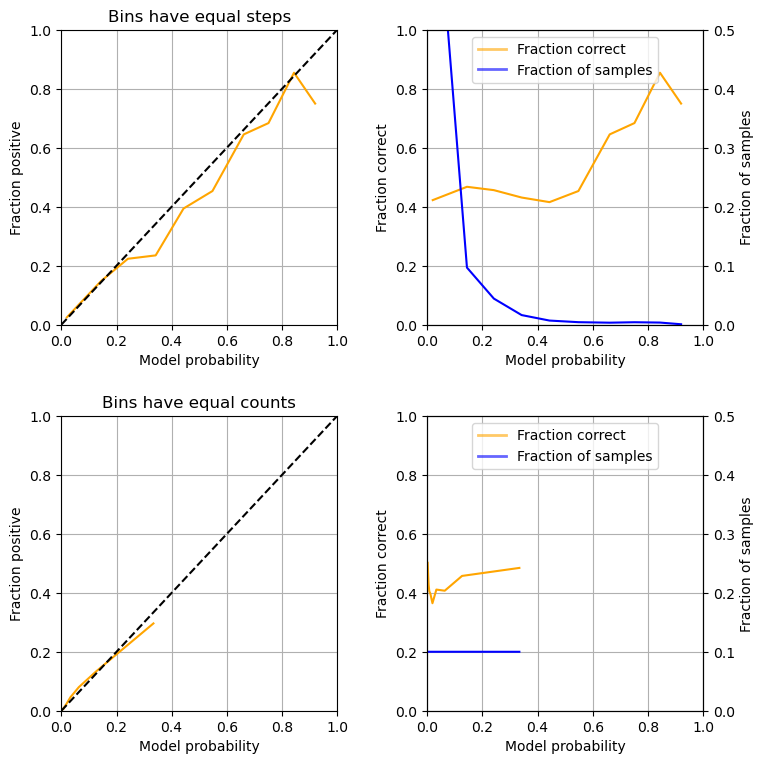

Results for class 6.0


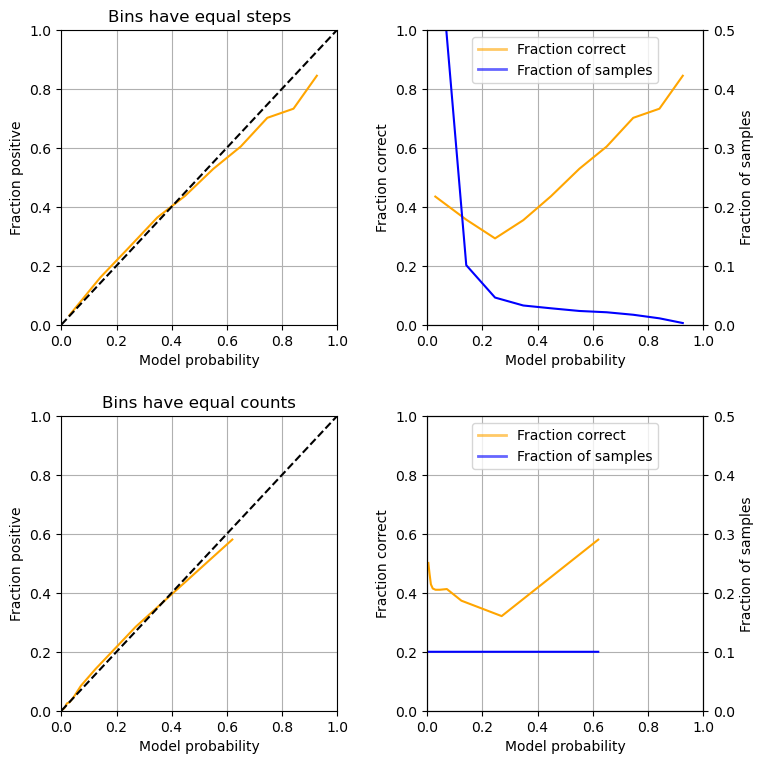

In [41]:
for c in class_names:
    subplot = 0
    print(f'Results for class {c}')

    fig = plt.figure(figsize=(8,8))

    for bin_method in ['steps', 'counts']:
        reliability_collated = (
                    dict_results[f'reliability_collated_{bin_method}_{c}'])

        # Plot predicted prob vs fraction psotive
        subplot+=1
        ax1 = fig.add_subplot(2,2,subplot)

        # Loop through k-fold reliability results
        for k in range(n_kfold):
            mask = reliability_collated['k-fold'] == k
            result_kfold = reliability_collated[mask]
            x = result_kfold['confidence']
            y = result_kfold['fraction_positive']
            ax1.plot(x,y, color='orange')
        # Add 1:1 line
        ax1.plot([0,1],[0,1], color='k', linestyle ='--')
        # Refine plot
        ax1.set_xlabel('Model probability')
        ax1.set_ylabel('Fraction positive')
        ax1.set_title(f'Bins have equal {bin_method}')
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)

        subplot+=1
        # Plot accuratest_data[k]cy vs probability
        ax2 = fig.add_subplot(2,2,subplot)
        # Loop through k-fold reliability results
        for k in range(n_kfold):
            mask = reliability_collated['k-fold'] == k
            result_kfold = reliability_collated[mask]
            x = result_kfold['confidence']
            y = result_kfold['fraction_correct']
            ax2.plot(x,y, color='orange')
        # Refine plot
        ax2.set_xlabel('Model probability')
        ax2.set_ylabel('Fraction correct')
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)

        # instantiate a second axes that shares the same x-axis
        ax3 = ax2.twinx()  
        for k in range(n_kfold):
            mask = reliability_collated['k-fold'] == k
            result_kfold = reliability_collated[mask]
            x = result_kfold['confidence']
            y = result_kfold['fraction_results']
            ax3.plot(x,y, color='blue')
            
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 0.5)
        ax3.set_ylabel('Fraction of samples')

        custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                        Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

        ax1.grid()
        ax2.grid()

        plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
                loc='upper center')

    plt.tight_layout(pad=2)
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                    paths.model_text + f'reliability_class_{c}.jpg'))

    plt.savefig(filename, dpi=300)
    plt.show()

### Reliability.

What's the accuracy of model, when model is at least 80% confident?

Look at the model predicting if instance is a class 0.

In [42]:
c = 0.0
reliability_summary = (dict_results[f'reliability_summary_steps_{c}'])
reliability_summary

bin_nominal  confidence  fraction_positive  fraction_correct  \
bin                                                                 
0.1          0.0    0.024915           0.027684          0.453661   
0.2          1.0    0.148422           0.141484          0.369702   
0.3          2.0    0.246889           0.245860          0.373248   
0.4          3.0    0.343825           0.356376          0.358711   
0.5          4.0    0.444528           0.454463          0.449955   
0.6          5.0    0.545702           0.558348          0.558348   
0.7          6.0    0.647252           0.639769          0.639769   
0.8          7.0    0.746161           0.708171          0.708171   
0.9          8.0    0.830765           0.839506          0.839506   
1.0          9.0    0.903975           1.000000          1.000000   

     fraction_results  
bin                    
0.1          0.598634  
0.2          0.151351  
0.3          0.116573  
0.4          0.063588  
0.5          0.032937  
0.6          0.016543  
0.7          0.010306  
0.8          0.007633  
0.9          0.002406  
1.0          0.000030

In [43]:
print ('For instances with at least 80% confidence from model')
print ()
for c in class_names:
    reliability_summary = (
                        dict_results[f'reliability_summary_steps_{c}'])

    bins = [0.9, 1.0]
    frac = reliability_summary.loc[bins].sum()['fraction_results']
    acc = ((reliability_summary.loc[bins]['fraction_correct'] * 
            reliability_summary.loc[bins]['fraction_results']).sum()/frac)

    print (f'PREDICTING CLASS: {round(c)}')
    print (f'Proportion of instances with >80% confidence: {frac:0.3f}')
    print (f'Accuracy for instances with >80% confidence: {acc:0.3f}')
    print ()

For instances with at least 80% confidence from model

PREDICTING CLASS: 0
Proportion of instances with >80% confidence: 0.002
Accuracy for instances with >80% confidence: 0.841

PREDICTING CLASS: 1
Proportion of instances with >80% confidence: 0.001
Accuracy for instances with >80% confidence: 0.634

PREDICTING CLASS: 2
Proportion of instances with >80% confidence: 0.000
Accuracy for instances with >80% confidence: 0.727

PREDICTING CLASS: 3
Proportion of instances with >80% confidence: 0.001
Accuracy for instances with >80% confidence: 0.780

PREDICTING CLASS: 4
Proportion of instances with >80% confidence: 0.003
Accuracy for instances with >80% confidence: 0.830

PREDICTING CLASS: 5
Proportion of instances with >80% confidence: 0.004
Accuracy for instances with >80% confidence: 0.839

PREDICTING CLASS: 6
Proportion of instances with >80% confidence: 0.013
Accuracy for instances with >80% confidence: 0.755



# KP YOU ARE HERE.

# WHICH KFOLD IS THIS FOR, AND WHICH CLASS??

# CHECK PLOT IS CORRECT

# CHECK WHAT THE DATAFRAMES RELIABILITY_SUMMARY AND RELIABILITY_CONFIDENCE HOLD?

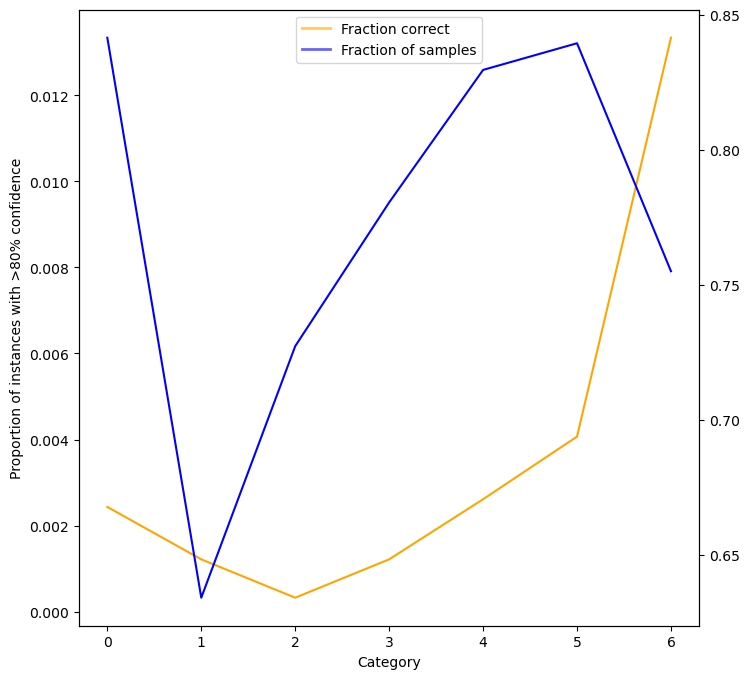

In [44]:
frac = []
acc = []
for c in class_names:
    reliability_summary = (
                        dict_results[f'reliability_summary_steps_{c}'])

    bins = [0.9, 1.0]
    frac.append(reliability_summary.loc[bins].sum()['fraction_results'])
    acc.append((reliability_summary.loc[bins]['fraction_correct'] * 
            reliability_summary.loc[bins]['fraction_results']).sum()/frac[-1])

fig = plt.figure(figsize=(8,8))

# Plot accuratest_data[k]cy vs probability
ax1 = fig.add_subplot(1,1,1)
ax1.plot(class_names,frac, color='orange')
# Refine plot
ax1.set_xlabel('Category')
ax1.set_ylabel('Proportion of instances with >80% confidence')
#ax2.set_xlim(0, 1)
#ax2.set_ylim(0, 1)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.plot(class_names, acc, color='blue')
        
#ax3.set_xlim(0, 1)
#ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Accuracy for instances with >80% confidence')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

#ax1.grid()
#ax2.grid()

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
        loc='upper center')

https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

https://github.com/Iditc/Posts-on-Medium/blob/main/Explainable%20AI/Explainable%20AI%20(XAI)%20with%20SHAP_MultiClass%20Classification%20Problem.ipynb

https://github.com/slundberg/shap/issues/367


In [45]:
shap_values_kfold[0].shape

(33670, 138, 7)

In [46]:
sv = shap_values_kfold[0]
sv = sv.transpose((2,0,1))
sv.shape

(7, 33670, 138)

In [47]:
shap_values_kfold0_list = shap_values_kfold[0].tolist()

In [48]:
len(shap_values_kfold0_list[0][0])

7

Making the 3D numpy array (shap_values1) match the list of 7 arrays (shap_values) by creating shap_values1_list, so it can be used in the shap.summary_plot

(took code in cell below from notebook 230614_xgb_all_data_multiclass_shap.ipynb)

shap.summary_plot does not take ax as an argument. So can not put them in a subplot.

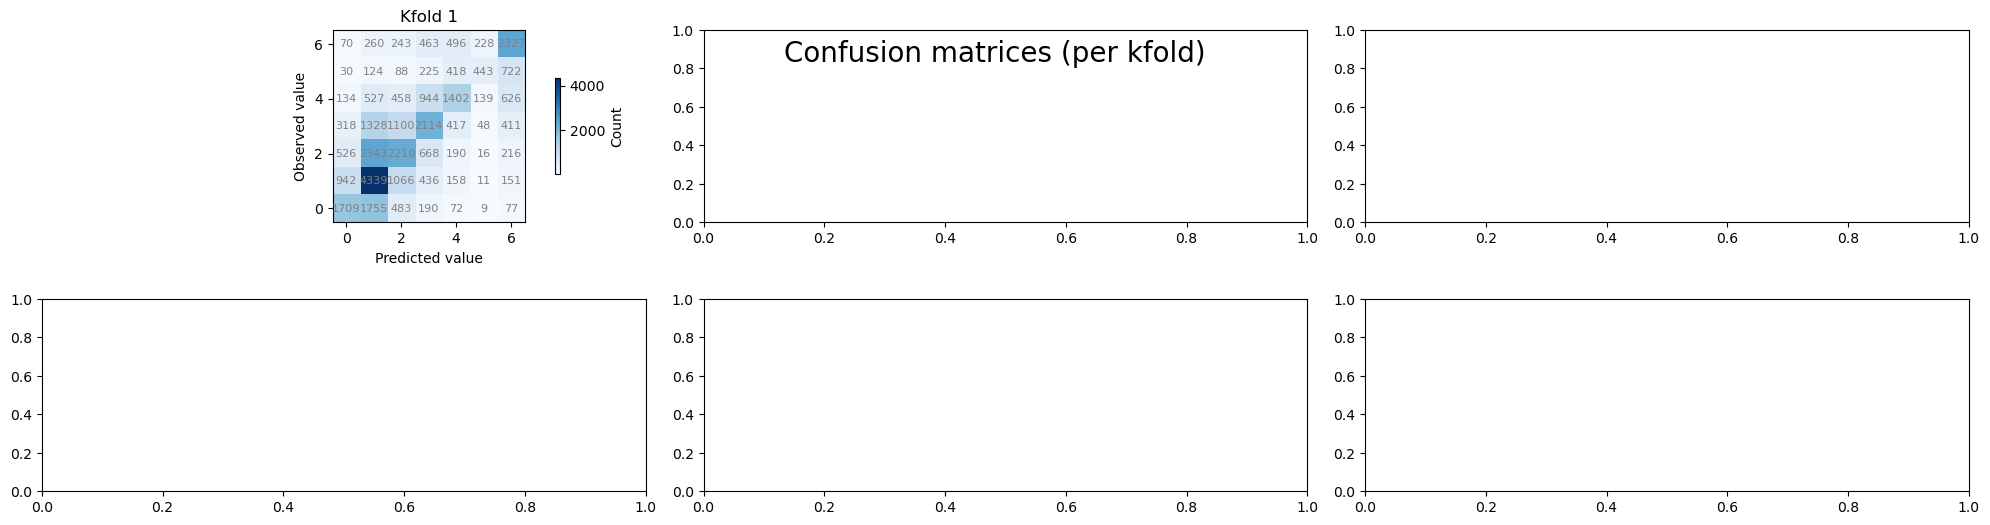

In [49]:
# Define for the figure
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15, 10))

fig.suptitle('Confusion matrices (per kfold)', fontsize=20)
fig.set_size_inches(20,5)
shrink = 0.5

row = 0
col = 0
for k in range(n_kfold):

    # Get axes
    ax = axs[row,col]
    # Set axis title
    ax.set_title(f'Kfold {k+1}')

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')
    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test, y_pred_kfold[k])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    #Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)


    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

    col += 1
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                paths.model_text + 'confusion_matrices_per_kfold.jpg')
                
plt.savefig(filename, dpi=300)

plt.show()

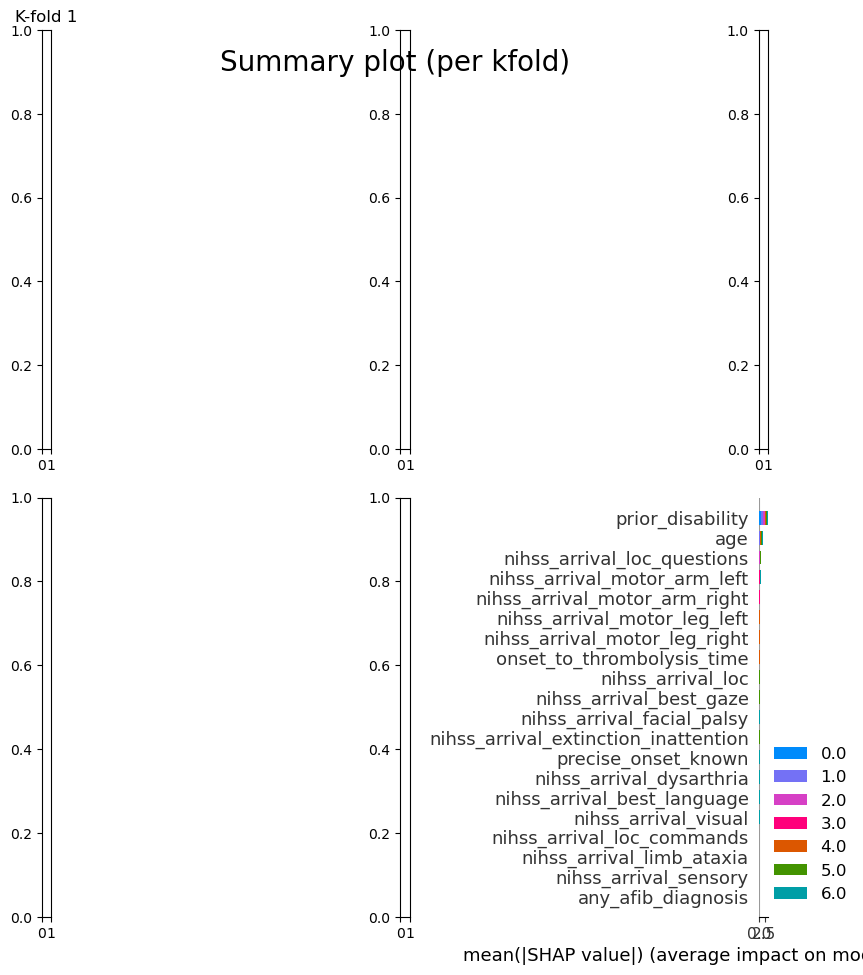

In [50]:
# Define for the figure
nrows = 2
ncols = 3
# using the variable axs for multiple Axes
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15, 10))


# Define for the figure
fig.suptitle('Summary plot (per kfold)', fontsize=20)
fig.set_size_inches(20,5)
shrink = 0.5


row = 0
col = 0

# Loop through the kfolds, subplot per kfold
for k in range(n_kfold):
     # Get axes
    ax = axs[row,col]
    # Set axis title
    ax.set_title(f'K-fold {k+1}')

    # Initialise empty list
    shap_values_list = []
    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Plot a SHAP summary plot, one for each k-fold
    ax = shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                           class_names=model.classes_, show=False,
                           feature_names = X_test.columns, class_inds="original")

    col += 1
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                paths.model_text + 'shap_summary_plot_per_kfold.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

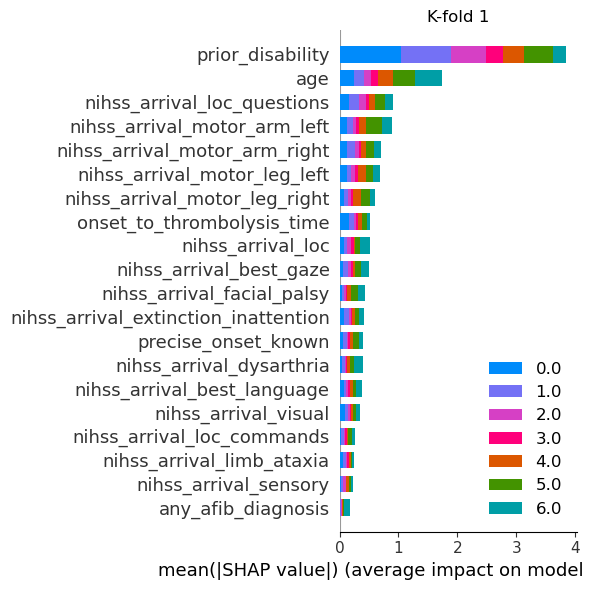

In [51]:
for k in range(n_kfold):
    # Initialise empty list
    shap_values_list = []
    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Plot a SHAP summary plot, one for each k-fold
    shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                      class_names=model.classes_, 
                      feature_names = X_test.columns, class_inds="original",
                      show=False, plot_size=(6,6))
    plt.title(f"K-fold {k+1}")
    plt.tight_layout()
    plt.show()

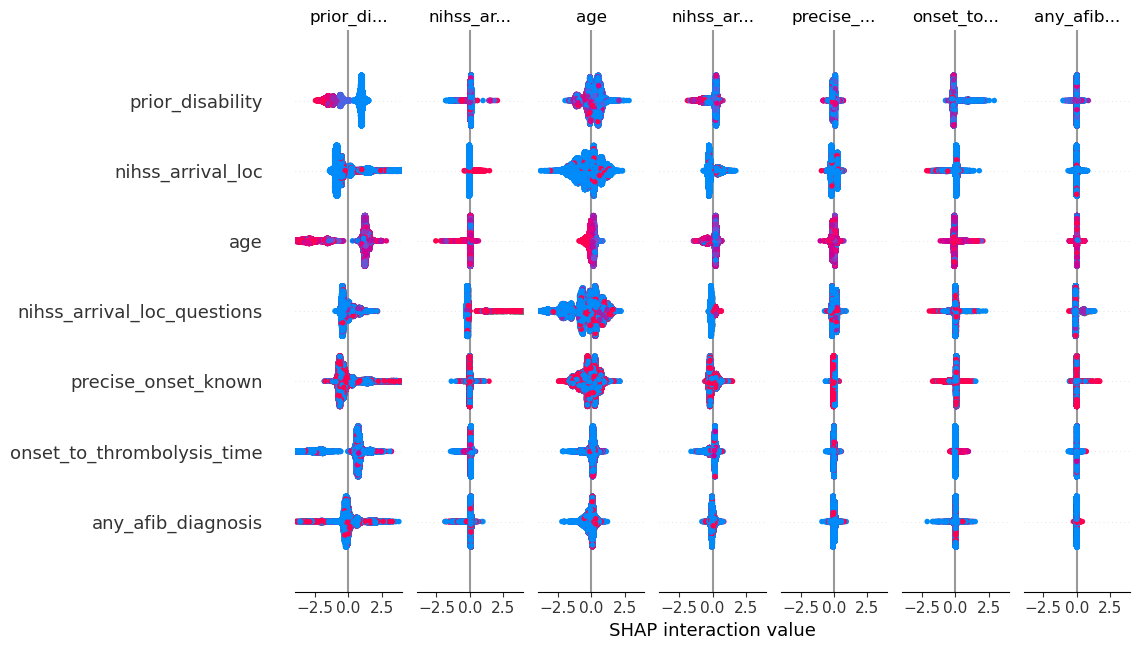

In [52]:
for k in range(n_kfold):
    # Initialise empty list
    shap_values_list = []
    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Plot a SHAP summary plot, one for each k-fold
    shap.summary_plot(shap_values_kfold[k], X_test.values, plot_type="bar", 
                  class_names= class_names, feature_names = X_test.columns, 
                  show=False, plot_size=(6,6))
    
    #plt.title(f"K-fold {k+1}")
    plt.tight_layout()
    plt.show()  
    


In [53]:
shap.plots.bar(shap_values_extended_kfold[k])

IndexError: list index out of range

In [ ]:
shap_values_extended_kfold[k].data.shape

(15363, 168)

shap_values_kfold[k][i, f, c]

You can also see the summary_plot of a specific class.

Loop through the classes, looking at just the one kfold.

shap_values_kfold[kfold][instance, feature, class]

In [ ]:
# Set the default text font size
plt.rc('font', size=8)
# Set the axes title font size
plt.rc('axes', titlesize=8)
# Set the axes labels font size
plt.rc('axes', labelsize=8)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=8)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=8)
# Set the legend font size
plt.rc('legend', fontsize=8)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)
plt.rcParams['font.size'] = 20

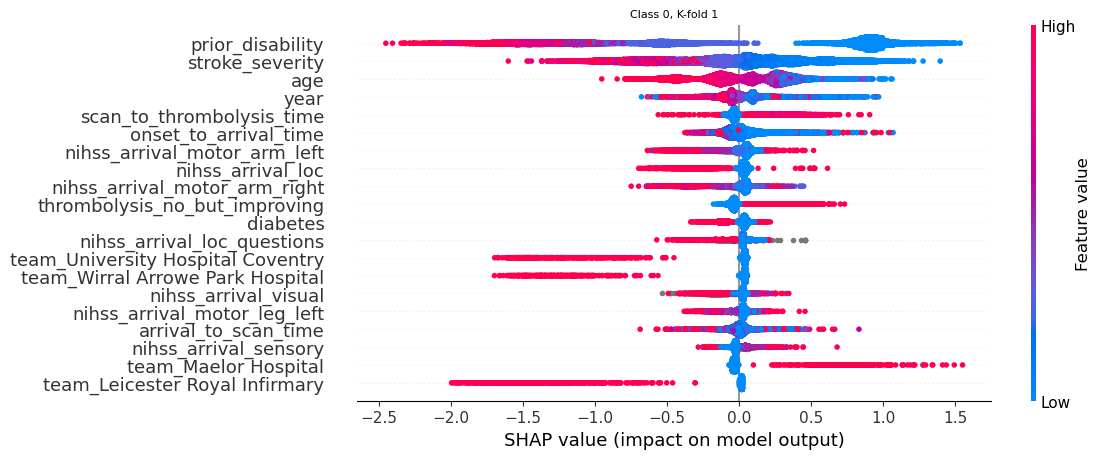

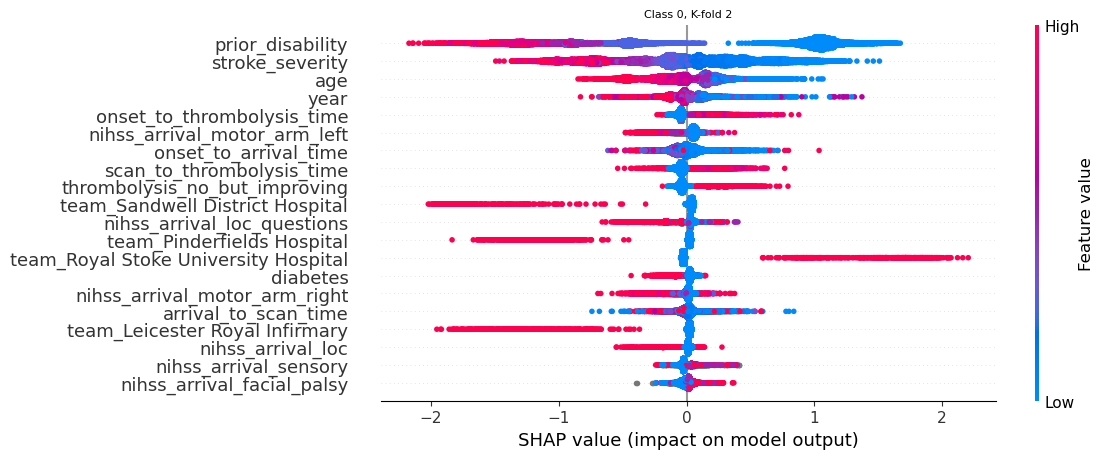

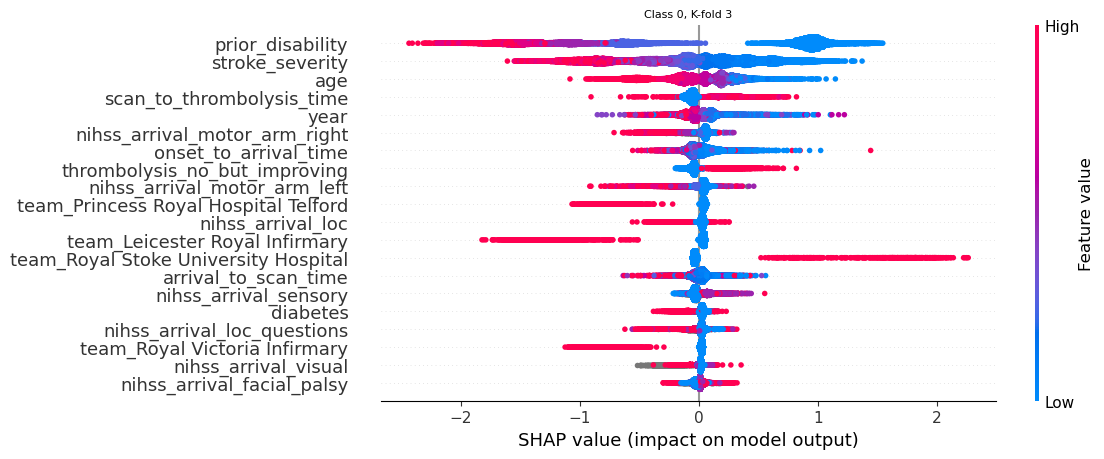

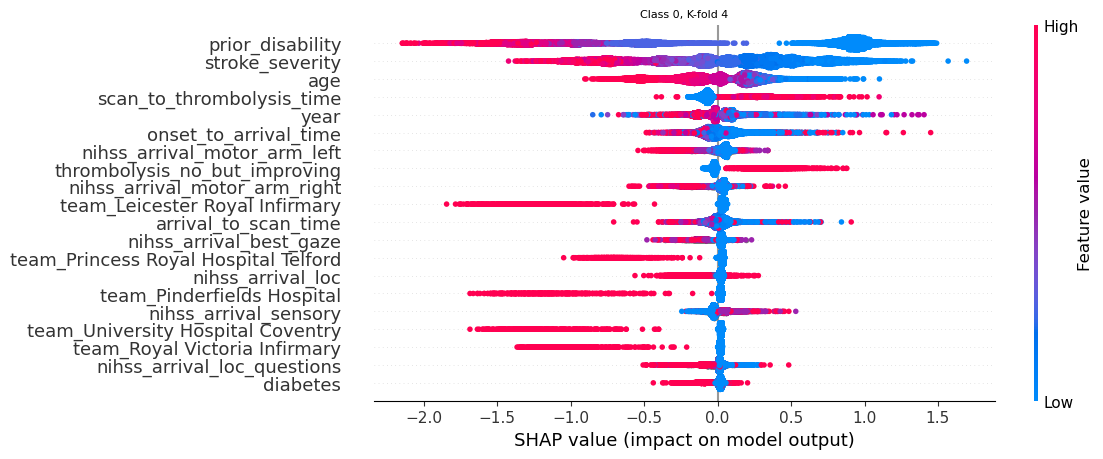

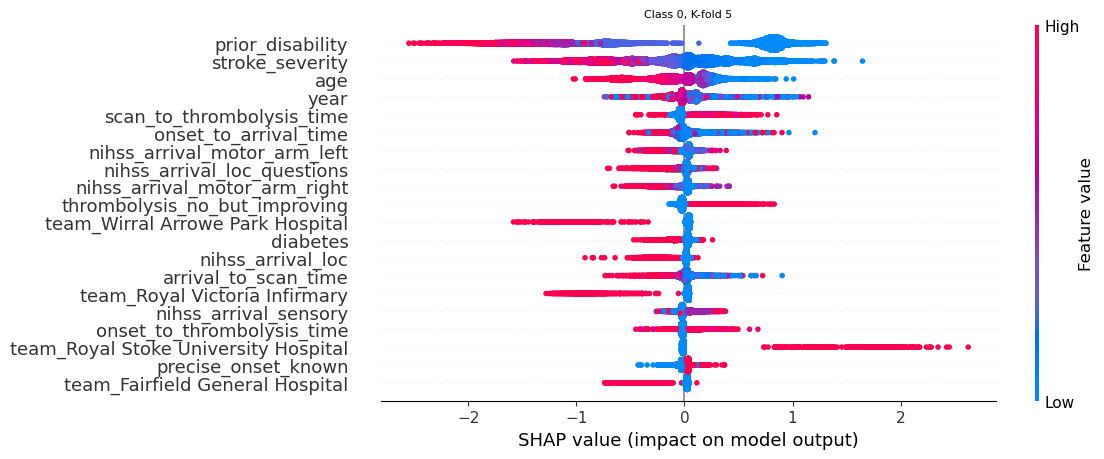

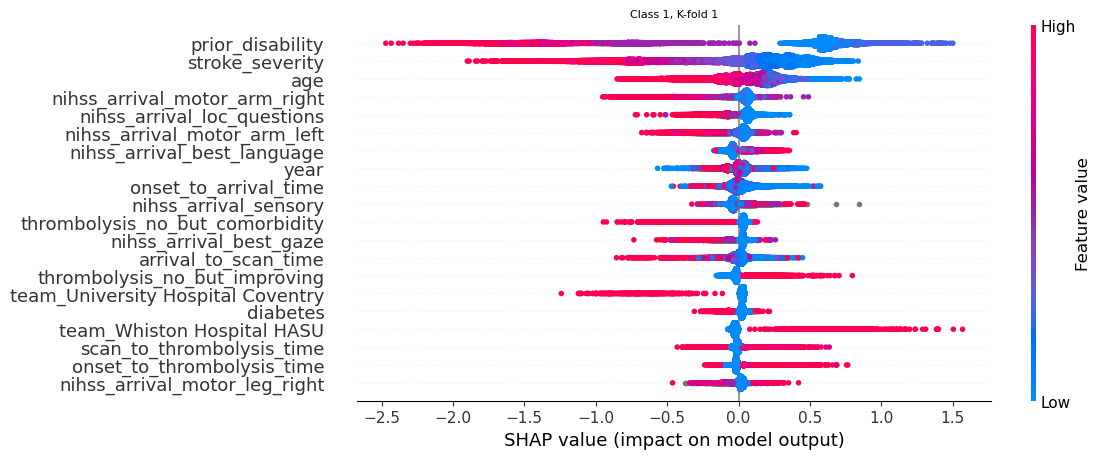

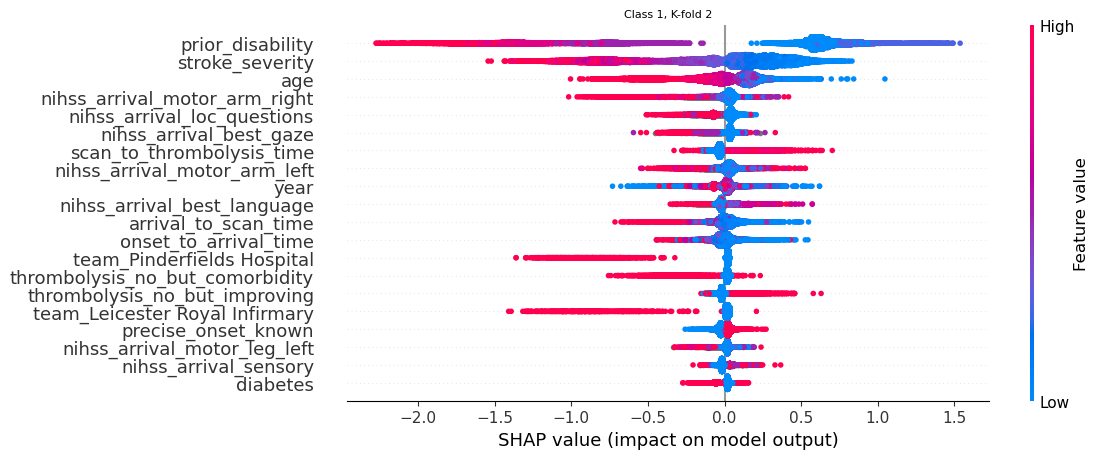

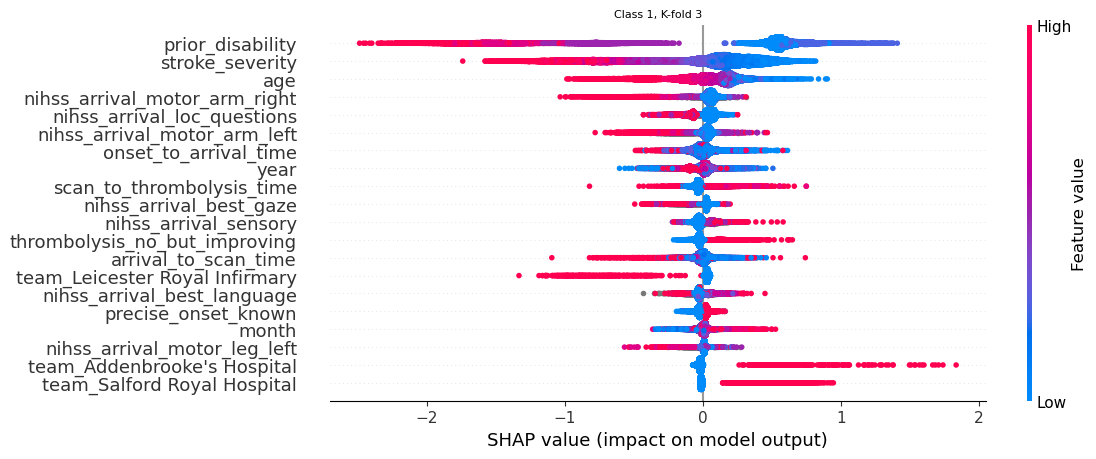

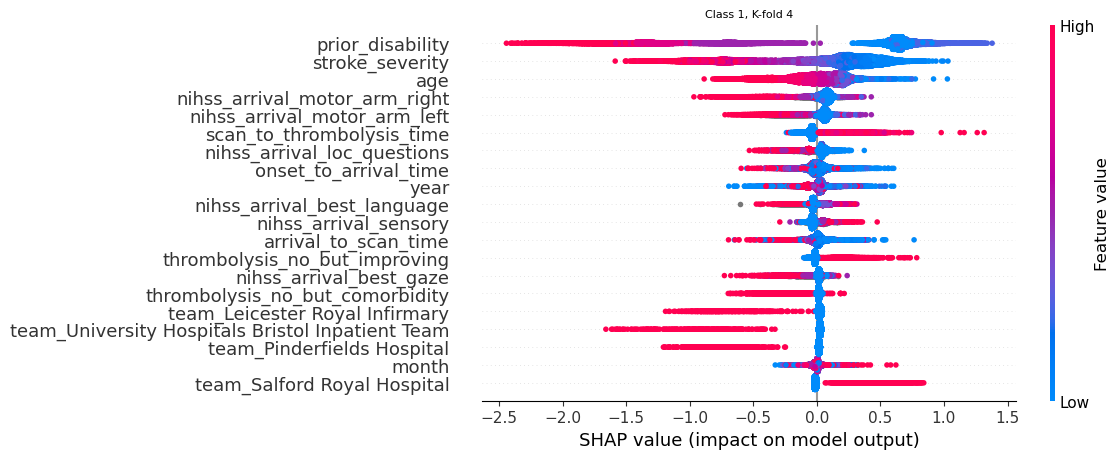

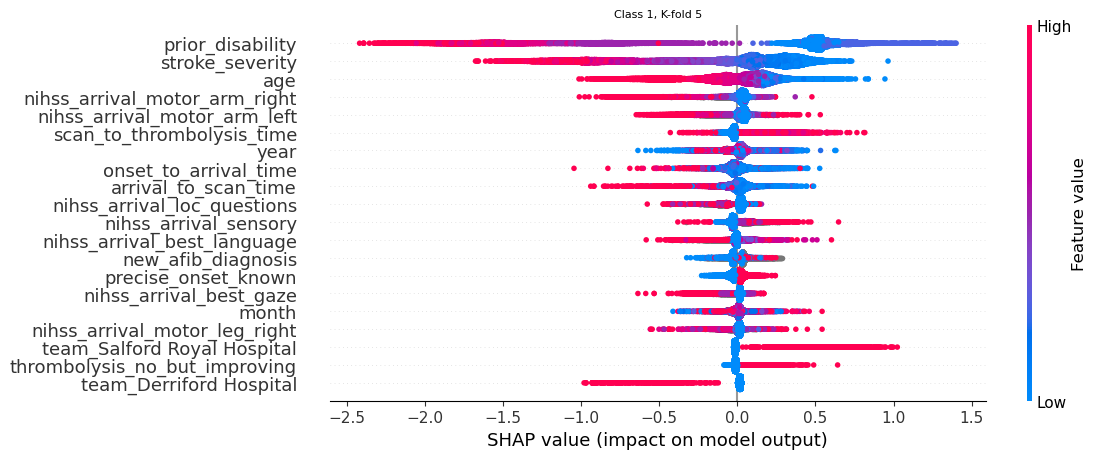

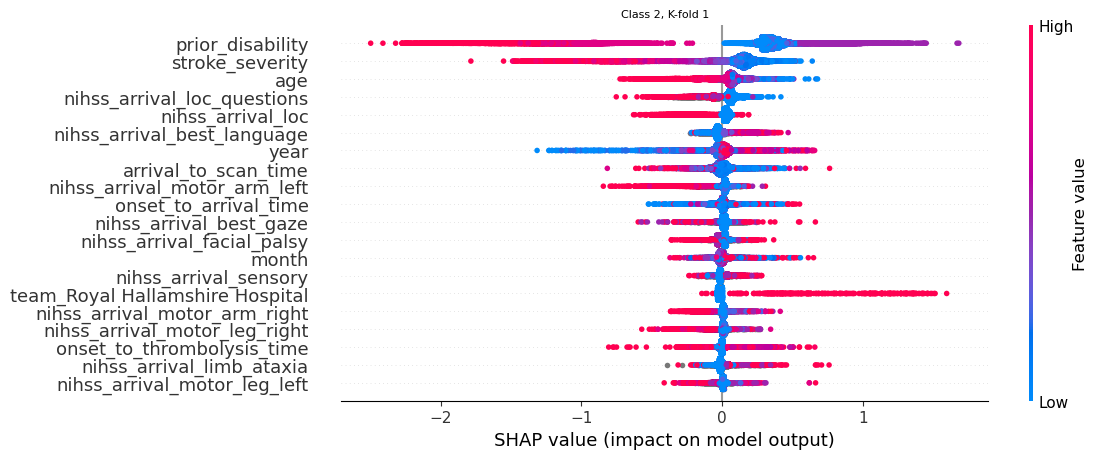

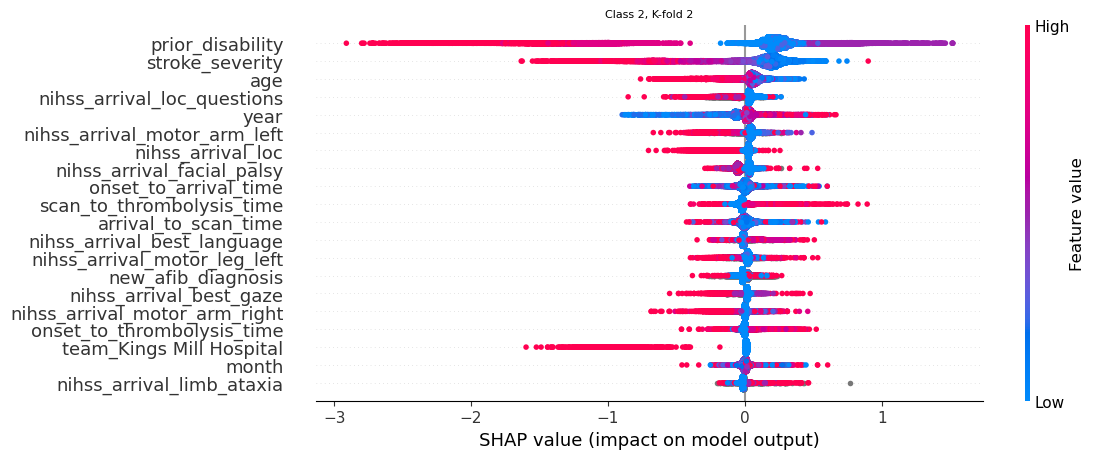

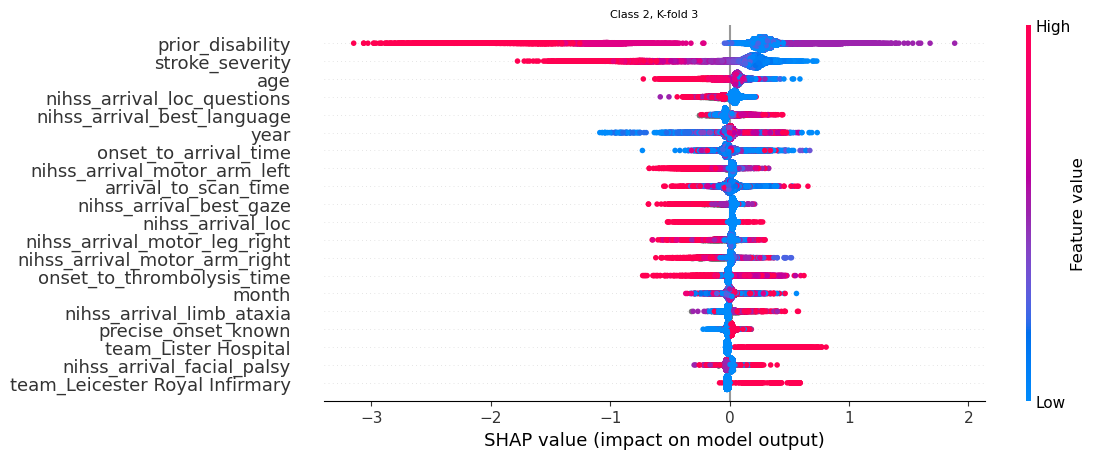

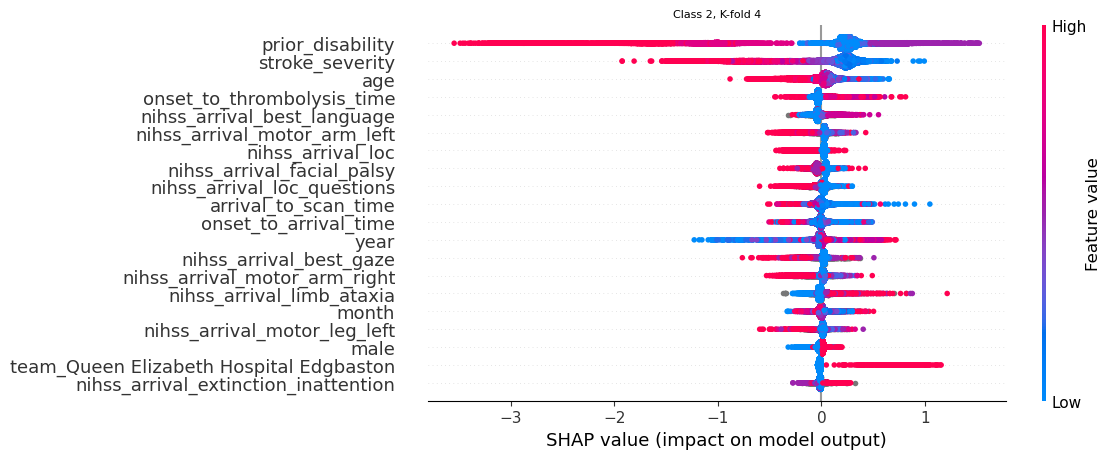

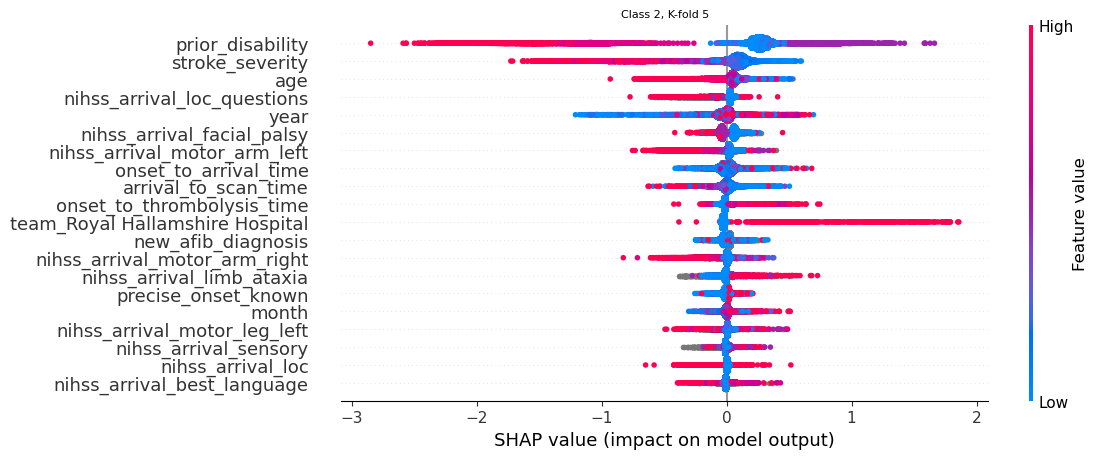

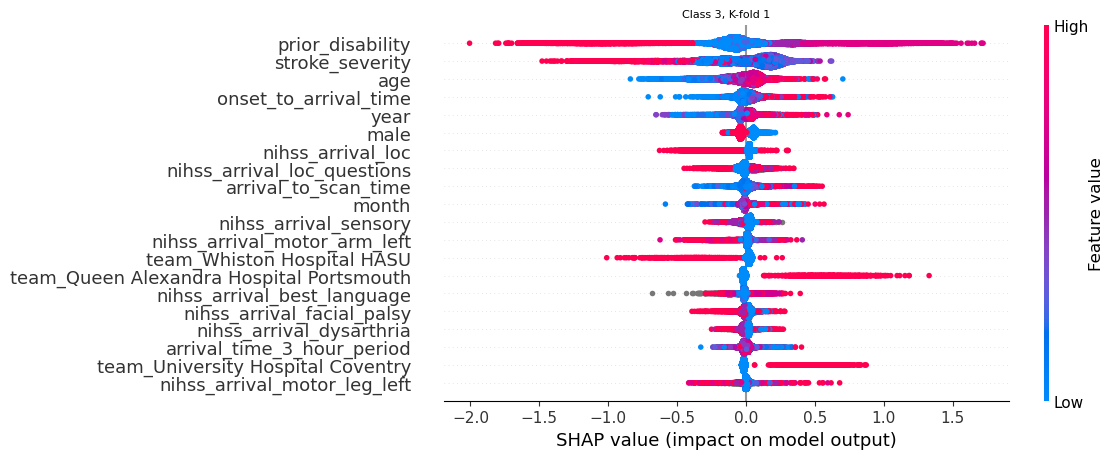

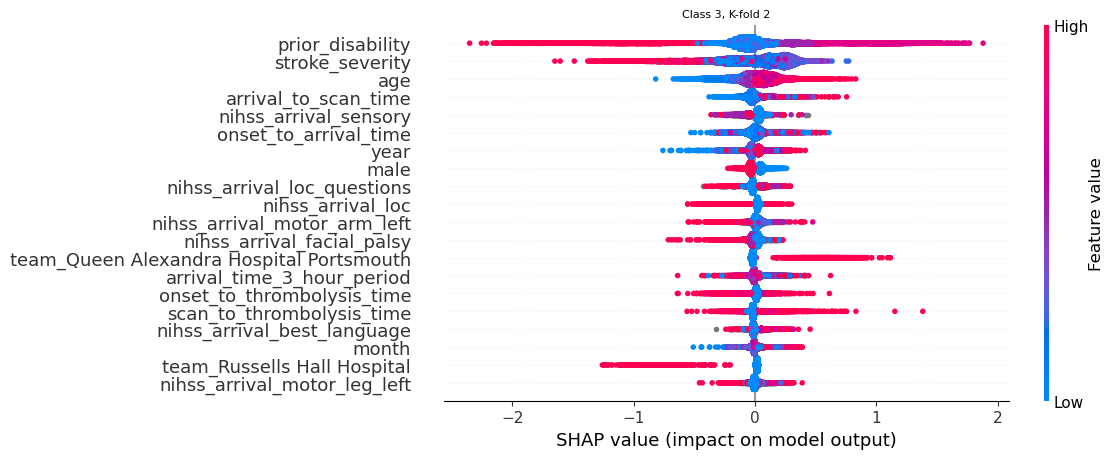

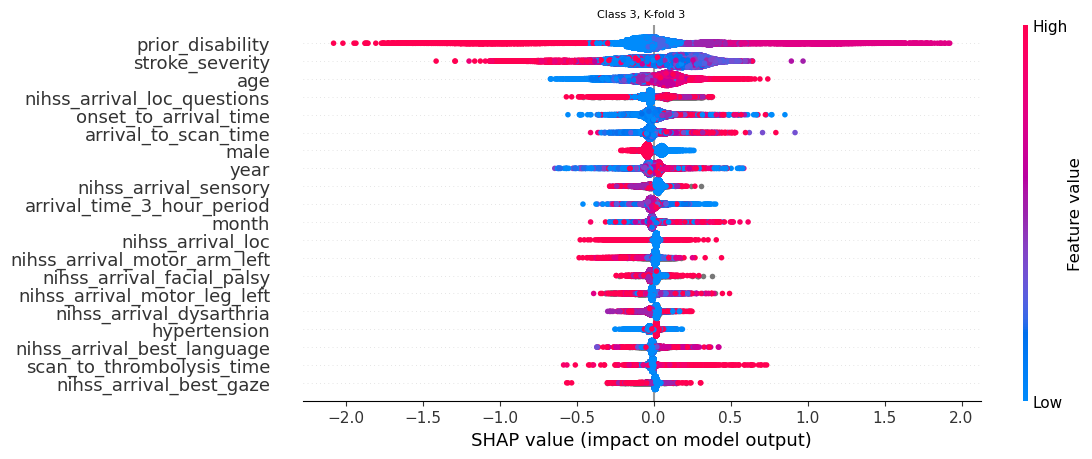

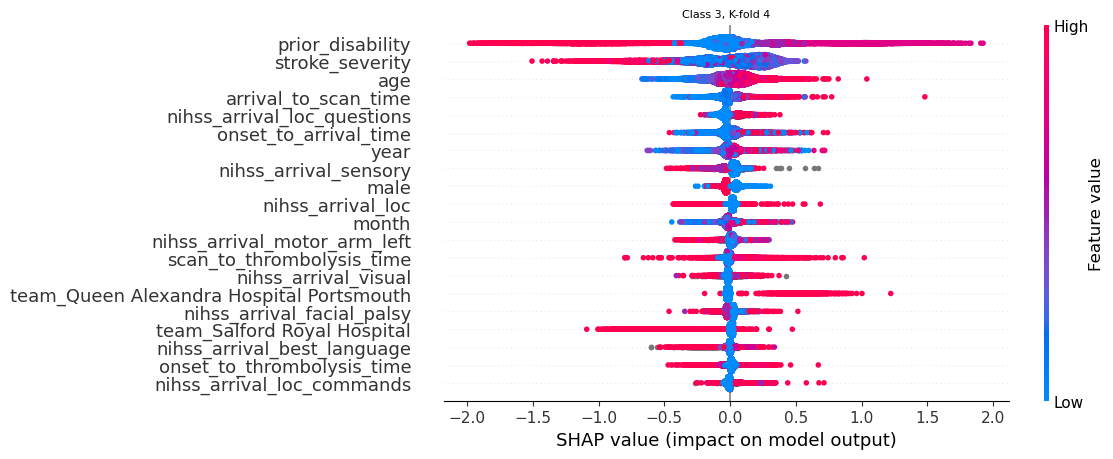

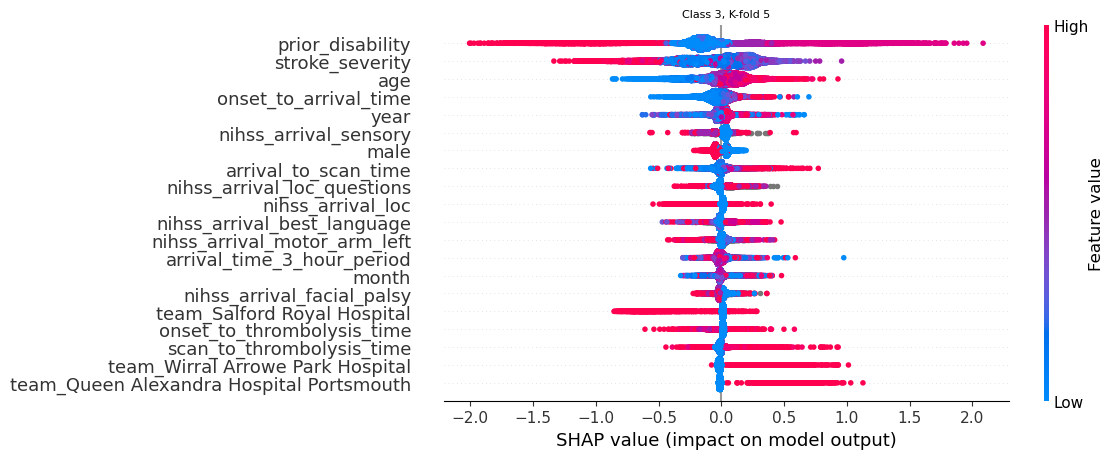

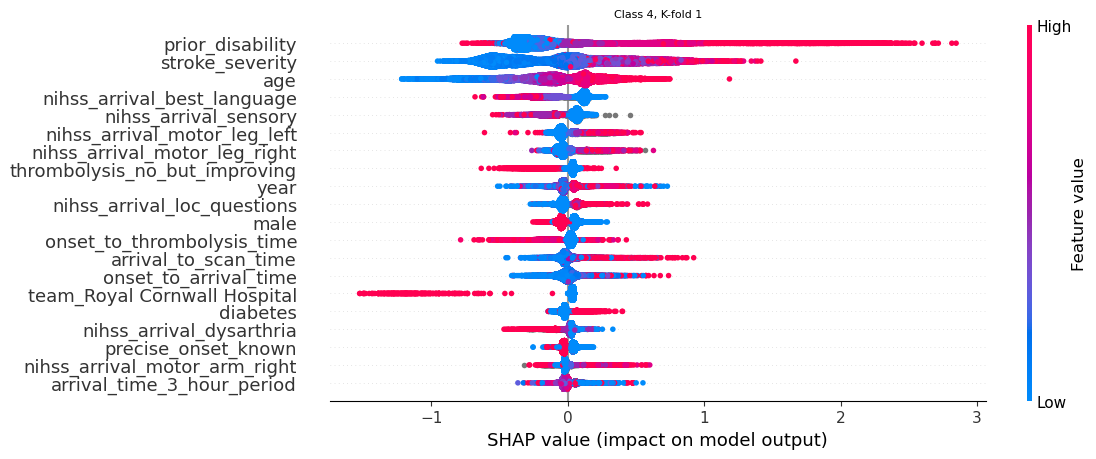

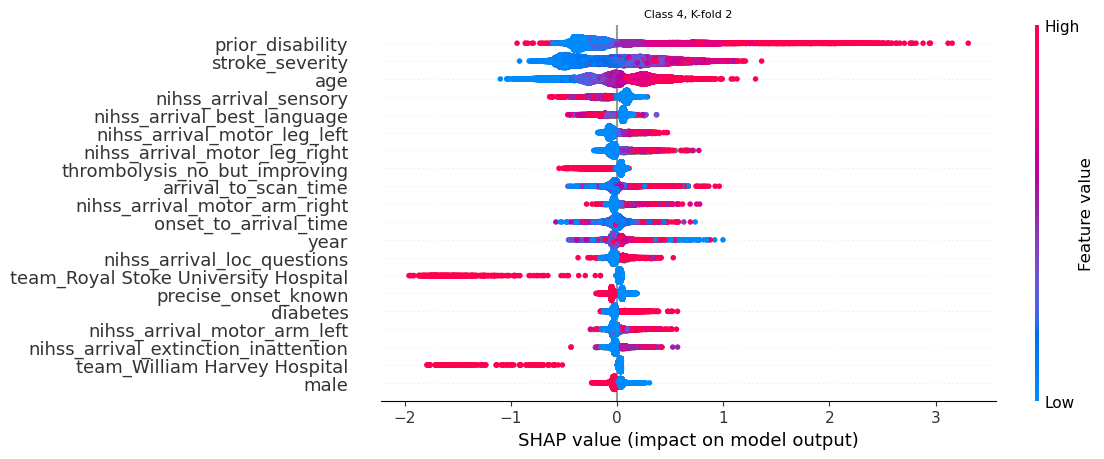

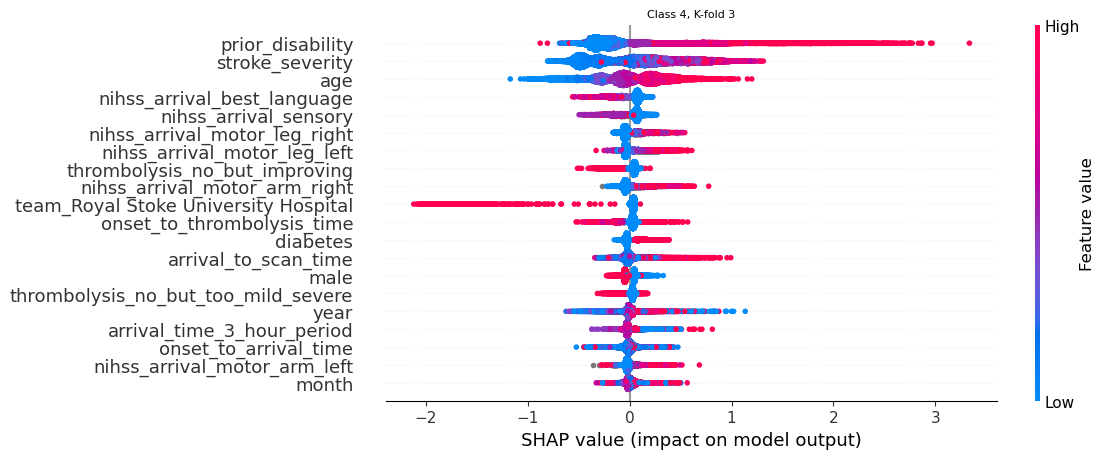

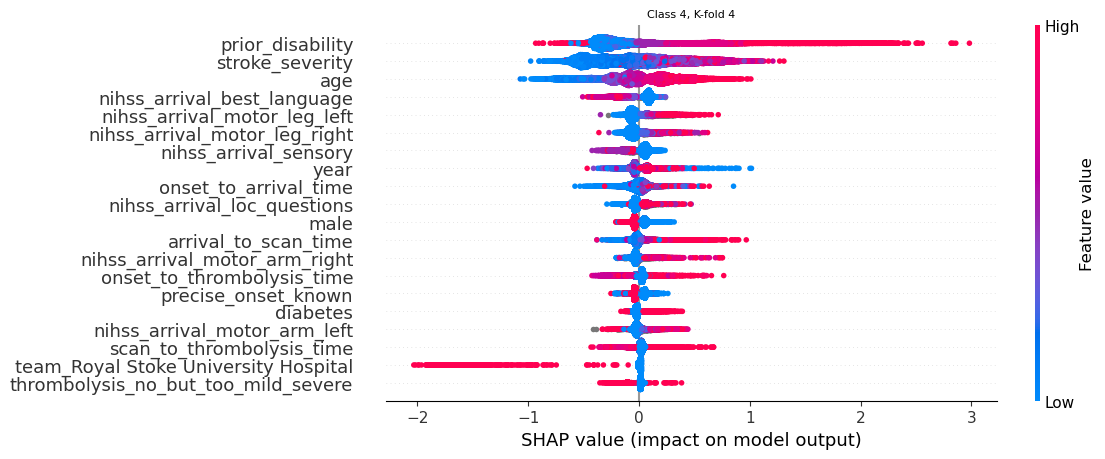

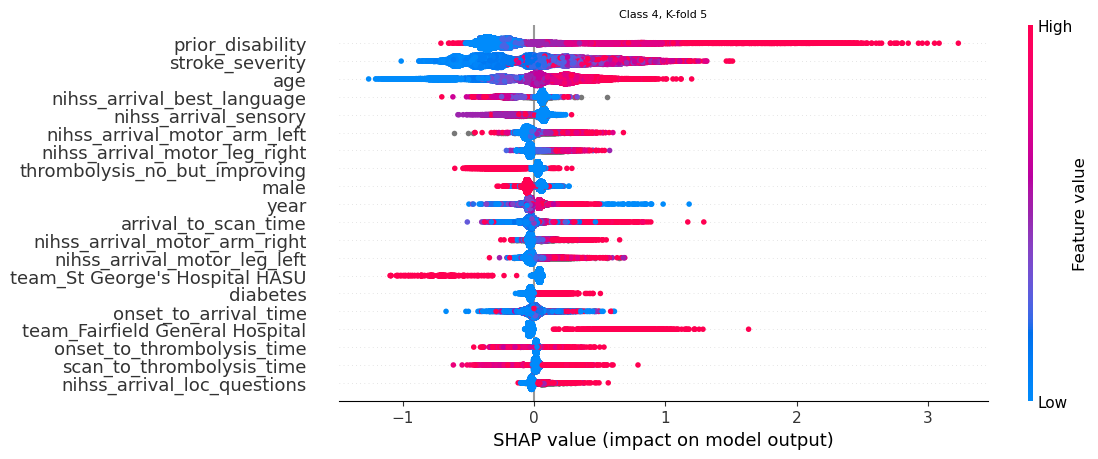

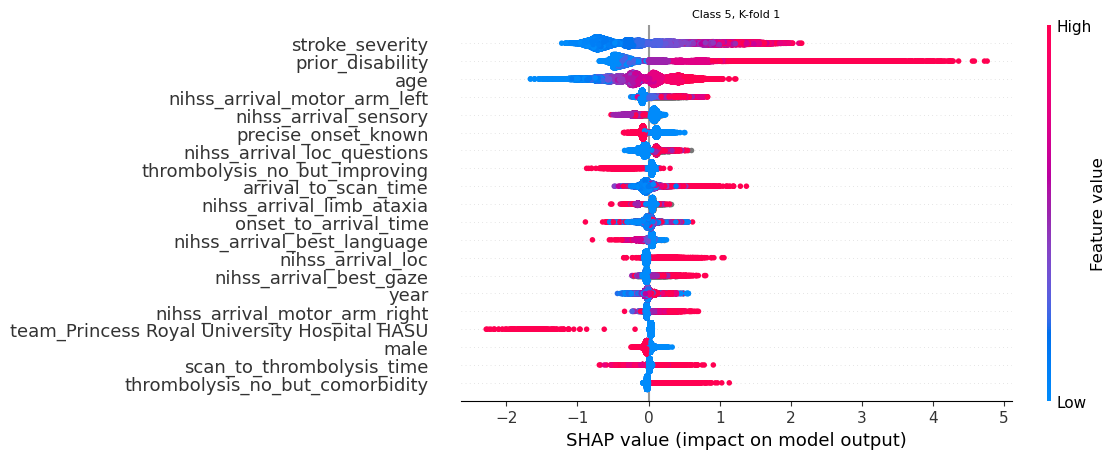

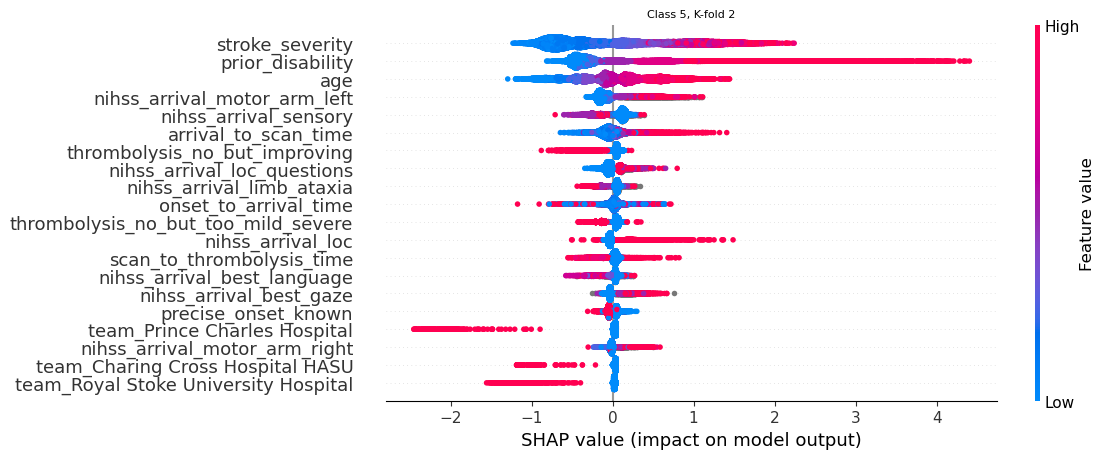

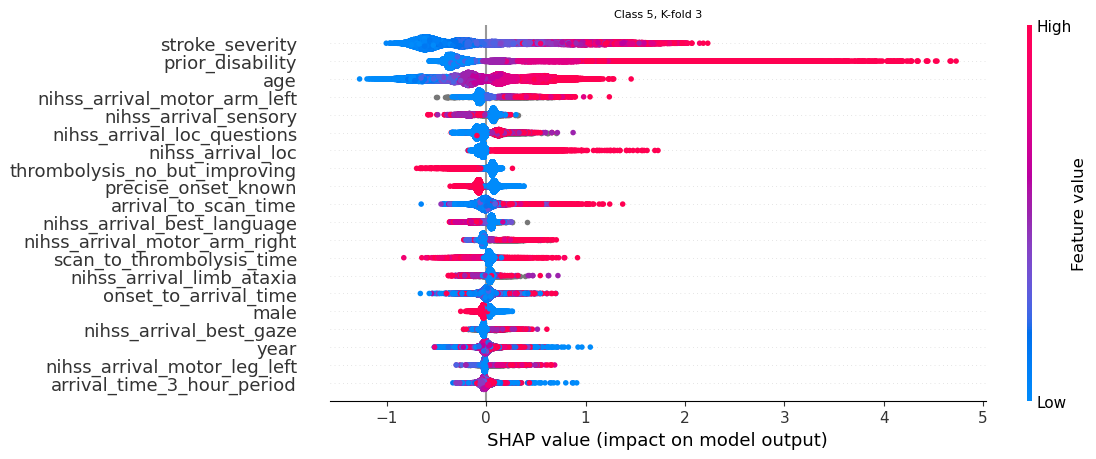

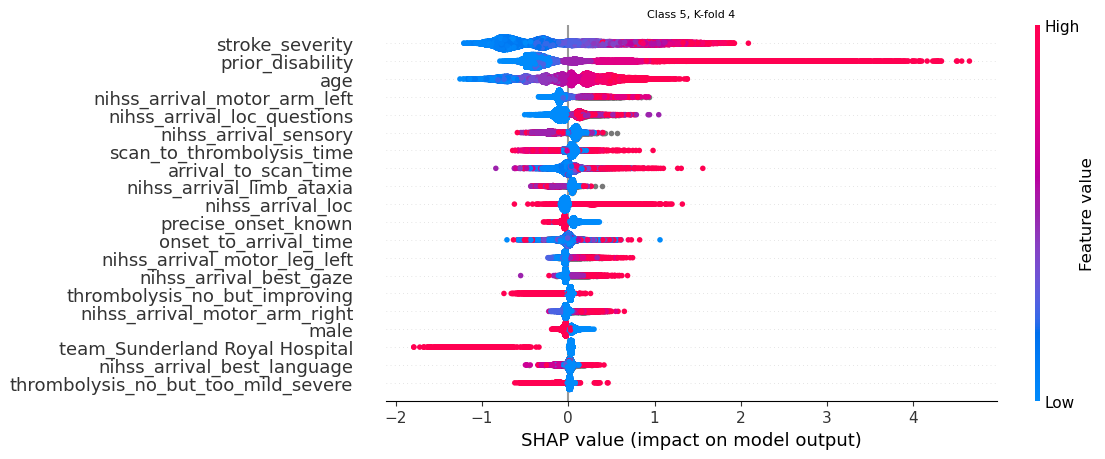

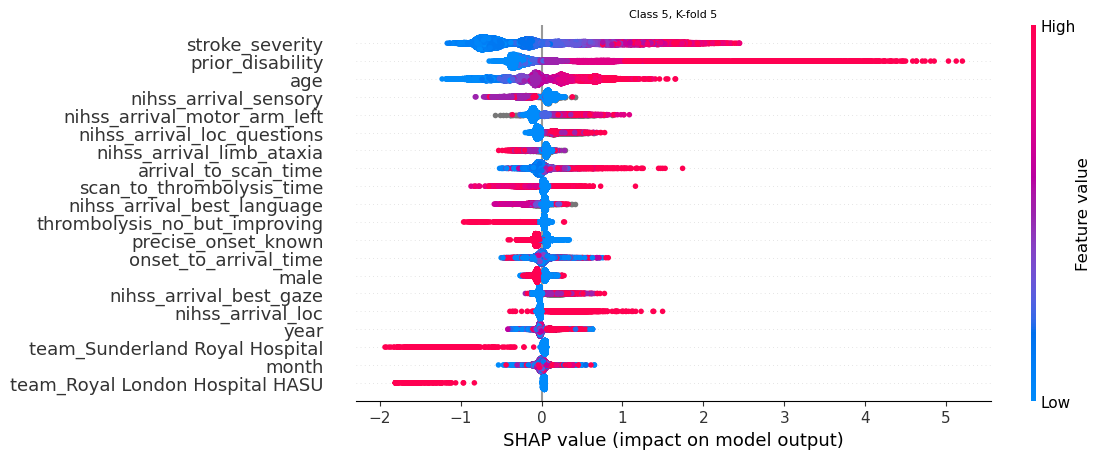

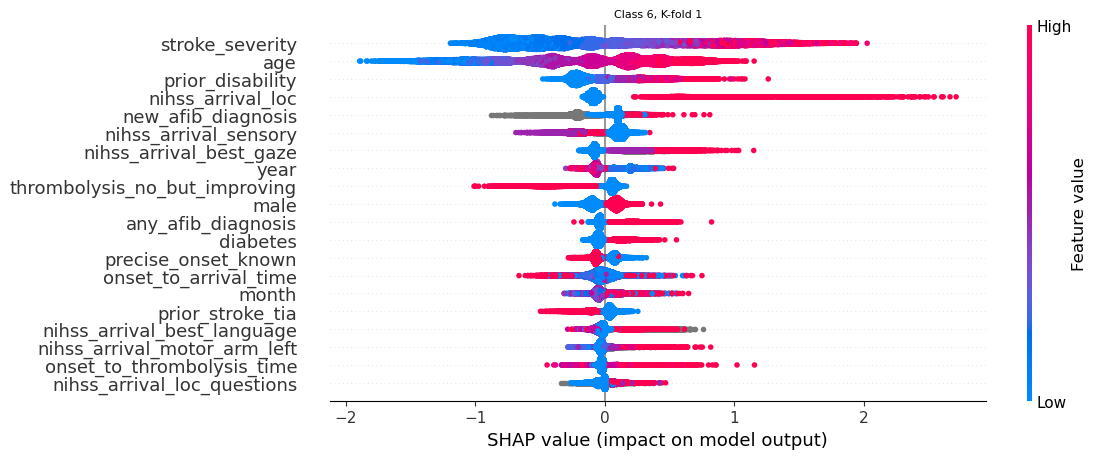

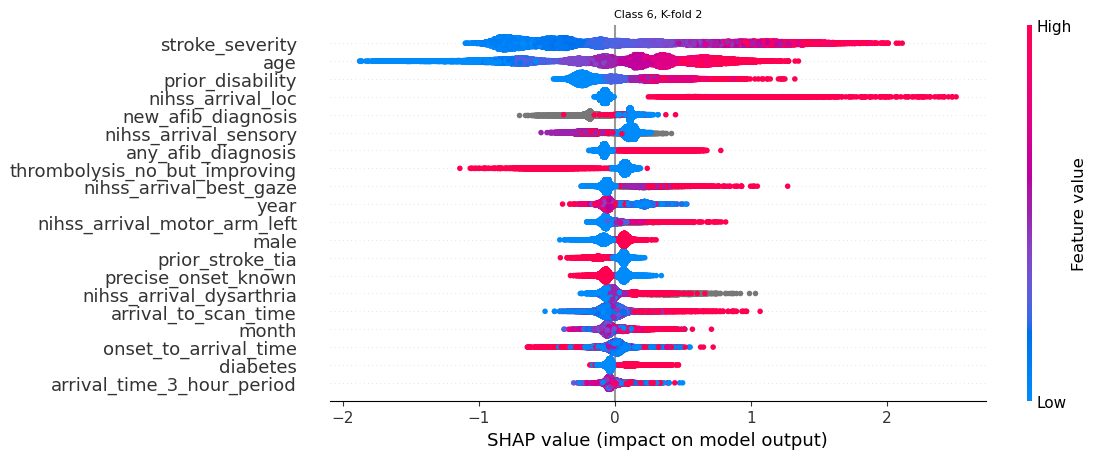

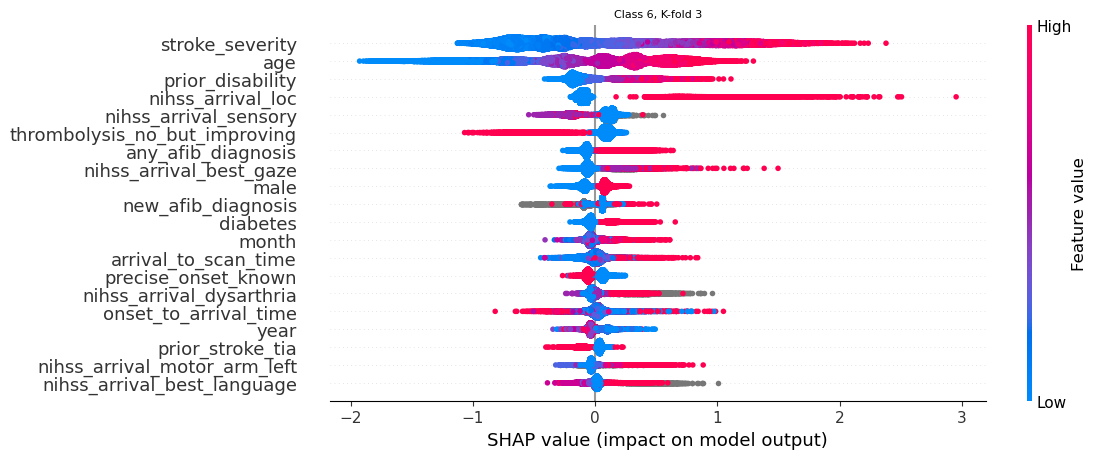

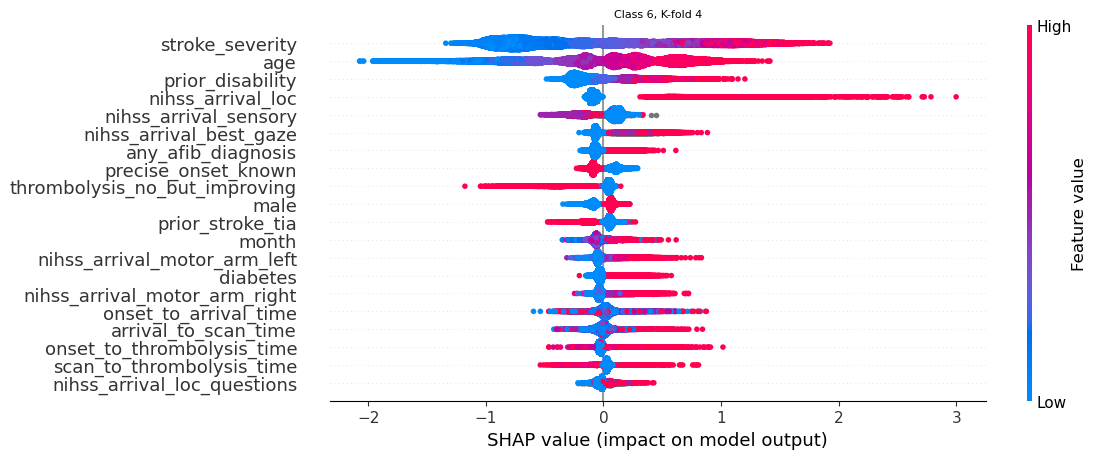

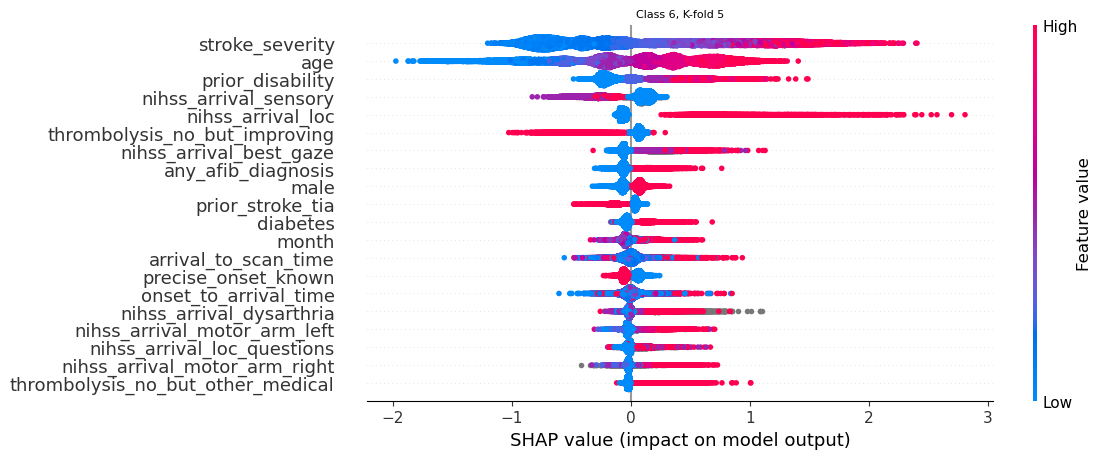

In [ ]:

for c in range(len(class_names)):
    for k in range(n_kfold):
        # Get k fold split
        (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                          test_data_kfold[k],
                                                          'discharge_disability')

        shap.summary_plot(shap_values_kfold[k][:,:,c], X_test.values, 
                        feature_names=X_test.columns, show=False, 
                        plot_size=(12,5))

        plt.title(f"Class {c}, K-fold {k+1}")
        plt.tight_layout()
        plt.show()

# OTHER VISUALISATIONS NOT YET TIDIED UP
1. dependence
2. waterfall
3. force

SHAP Dependence Plot

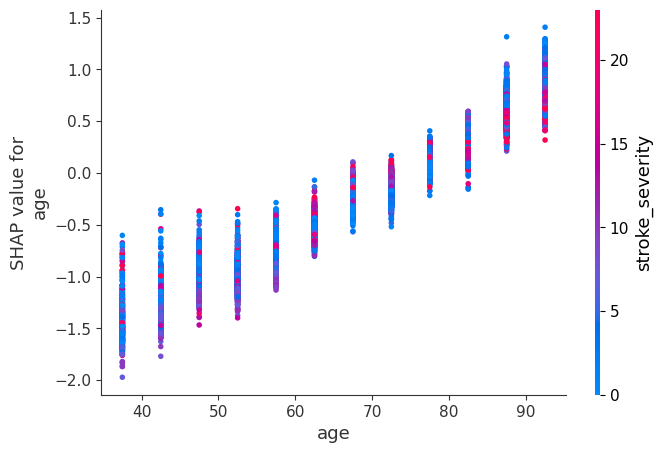

In [ ]:
shap.dependence_plot(0, shap_values, X_test.values, feature_names=X_test.columns)

SHAP Force plot

In [ ]:
i=8
shap.force_plot(explainer.expected_value[0], shap_values_kfold[0][i], X_test.values[i], feature_names = X_test.columns)

SHAP waterfall plot

In [ ]:
row = 8
shap.waterfall_plot(shap.Explanation(values=shap_values_kfold[0][row], 
                                              base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                         feature_names=X_test.columns.tolist()))

Store information from this notebook in a dictionary.

Pickle the dictionary containing information from this notebook to access in the comparison notebook '0499_cllating_the_results_of_feature_combinations.ipynb'

In [ ]:
dict_model = {}
dict_model['n_kfold'] = n_kfold
dict_model['paths'] = paths
dict_model['train_data_kfold'] = train_data_kfold
dict_model['test_data_kfold'] = test_data_kfold
dict_model['model_kfold'] = model_kfold
dict_model['y_probs_kfold'] = y_probs_kfold
dict_model['y_pred_kfold'] =  y_pred_kfold
dict_model['roc_auc_ovr_kfold'] = roc_auc_ovr_kfold
dict_model['accuracy_kfold'] =  accuracy_kfold
dict_model['error_within_one_kfold'] =  error_within_one_kfold
dict_model['feature_importance_kfold'] = feature_importance_kfold

# Save using pickle
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_dictionary.p'))
with open(filename, 'wb') as filehandler:
    pickle.dump(dict_model, filehandler)

## Extra analysis

Here to not clog up that main notebook

### ROC Curve - One vs One (OvO)

Compares each possible combination of the classes, two at a time.

As this is run for each kfold, this is a lot of output. Here show it just for the first kfold (and use the analysis in the notebook looking at one vs rest for the kfold consistency analysis)

In [ ]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(len(class_list)):
        if i != j:
            classes_combinations.append([i, j])

In [ ]:
k = 0

# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                    test_data_kfold[k],
                                                    'discharge_disability')

In [ ]:
n_categories = len(classes)

# Plots the Probability Distributions and the ROC Curves One vs ONe
fig_height = 6 * (n_categories-1)

plt.figure(figsize = (20, fig_height))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

# For subplot placement
col_top = 0
group_count = 0

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = str(c1) + " vs " + str(c2)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()#X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_probs[k][:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    group_count += 1
    col_top += 1
    if group_count == (n_categories):
        group_count = 1
        col_top = col_top + (n_categories-1)
        
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2*n_categories, n_categories-1, col_top)#ax = plt.subplot(2, len(classes_combinations), i+1)
    sns.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, 
                 bins=bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    col_bottom = col_top + (n_categories-1)
    ax_bottom = plt.subplot(2*n_categories, n_categories-1, col_bottom)
#   ax_bottom = plt.subplot(2, len(classes_combinations), i+len(classes_combinations)+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax=ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                paths.model_text + f'_rocauc_heatmap_kfold{k}.jpg')
plt.savefig(filename, dpi=300)

To interpret these OvO graphs, look at the x axis to see which category the probability is being shown for. Orange shows the instances that have that classification. Blue shows the instances that have another classification (as shown on the title or legend).

The better the model determines the difference between these two classes, the more separate the two histogram (orange to the right - many instances close to probability of 1, with blue to the left - many instances with a probability close to 0)

Top left graph narrative: Showing the probability of being class 0. Orange show range of probabilities to be 0 for those instances that are 0. Blue show range of probabilities to be 0 for those instances that are 1.

Bottom gright graph narrative: Showing the probability of being class 6. Orange show range of probabilities to be 6 for those instances that are 6. Blue show range of probabilities to be 6 for those instances that are 5.

Show the ROC AUC for the OvO as a heat map.
First prepare the data

In [ ]:
n_categories = len(class_list)

roc_auc_ovo_array = np.empty((n_categories,n_categories), dtype=object)

# Displays the ROC AUC for each class
for k in roc_auc_ovo:
    roc_auc_ovo_array[int(k[0]),int(k[-1])] = roc_auc_ovo[k]

# No entry for diagonal, fill with zero
np.fill_diagonal(roc_auc_ovo_array, 0)

# Convert to flaot
roc_auc_ovo_array = roc_auc_ovo_array.astype(float)

Plot the ROCAUC heatmap
The placement is the output class, the value is how well the model classifies the correct class from one other class.

In [ ]:
# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(roc_auc_ovo_array, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(roc_auc_ovo_array)):
    for j in range(len(roc_auc_ovo_array[0])):
        plt.text(j, i, roc_auc_ovo_array[i][j].round(2), ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

# EXTRA CELLS

Trying to put shap.summary_plot in a subplot. But is does not take argument ax
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html

In [ ]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15, 10))

row = 0
col = 0
for k in range(n_kfold):
#    ax1 = fig.add_subplot(2,3,k+1)

    # Initialise empty list
    shap_values_list = []
    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Plot a SHAP summary plot, one for each k-fold
    shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                      class_names=model.classes_, 
                      feature_names = X_test.columns, class_inds="original",
                      show=False, ax=axes[row,col])
    col += 1
    if col > ncols: 
        col = 1
        row += 1
    plt.tight_layout()

Started to look at difference background data makes

In [ ]:
k = 0

# Calculate SHAP values
# Get k fold split
train = train_data_kfold[k]
test = test_data_kfold[k]

# Get X and y
X_train = train.drop('discharge_disability', axis=1)
X_test = test.drop('discharge_disability', axis=1)
y_train = train['discharge_disability']
y_test = test['discharge_disability']

# WHAT'S THE DIFFERENCE BETWEEN:

# 1

# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model_kfold[k])#, X_train)
shap_values = explainer.shap_values(X_test)

# 2
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model_kfold[k], X_train)
# Get (and store) Shapley values along with base and feature values
shap_values_extended = explainer(X_test)
# Shap values exist for each classification in a Tree
shap_values = shap_values_extended.values

shap.summary_plot(shap_values, X_test.values, plot_type="bar", 
                  class_names= class_names, feature_names = X_test.columns)

Trying with https://towardsdatascience.com/how-to-easily-customize-shap-plots-in-python-fdff9c0483f2

In [ ]:
fig = plt.figure()



plt.gcf().set_size_inches(20,6)
plt.tight_layout() 
plt.show()


k = 0

shap_values_list = []
# Putting the SHAP values in the required format
for c in range(n_classes):
    shap_values_list.append(shap_values_kfold[k][:,:,c])

# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                    test_data_kfold[k],
                                                    'discharge_disability')

ax0 = fig.add_subplot(1,2,1)
# Plot a SHAP summary plot, one for each k-fold
shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                    class_names=model.classes_, 
                    feature_names = X_test.columns, class_inds="original",
                    show=False, plot_size=(6,6))

ax1 = fig.add_subplot(1,2,2)
# Plot a SHAP summary plot, one for each k-fold
shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                    class_names=model.classes_, 
                    feature_names = X_test.columns, class_inds="original",
                    show=False, plot_size=(6,6))

plt.gcf().set_size_inches(20,6)
plt.tight_layout() 
plt.show()

Creating subplots with tuple and creating a separate disctionary. Before found subplots can return an array of Axes
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html 

In [ ]:
# Set up the figure and the axes
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

# Create a dictionary of the axes so can loop through them
dict_axes = {}
dict_axes['ax1'] = ax1
dict_axes['ax2'] = ax2
dict_axes['ax3'] = ax3
dict_axes['ax4'] = ax4
dict_axes['ax5'] = ax5

# Define for the figure
fig.suptitle('Confusion matrices (per kfold)', fontsize=20)
fig.set_size_inches(20,5)
shrink = 0.5

# Loop through the kfolds, subplot per kfold
for k in range(n_kfold):
    # Get axes
    ax = dict_axes[f'ax{k+1}']
    # Set axis title
    ax.set_title(f'Kfold {k+1}')

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')
    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test, y_pred_kfold[k])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    #Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                paths.model_text + 'confusion_matrices_per_kfold.jpg')
                
plt.savefig(filename, dpi=300)

plt.show()